<a href="https://colab.research.google.com/github/geogav/morphophen_networks_spatial/blob/main/notebooks/Morphophen_Single_cell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Single-cell basic analysis**

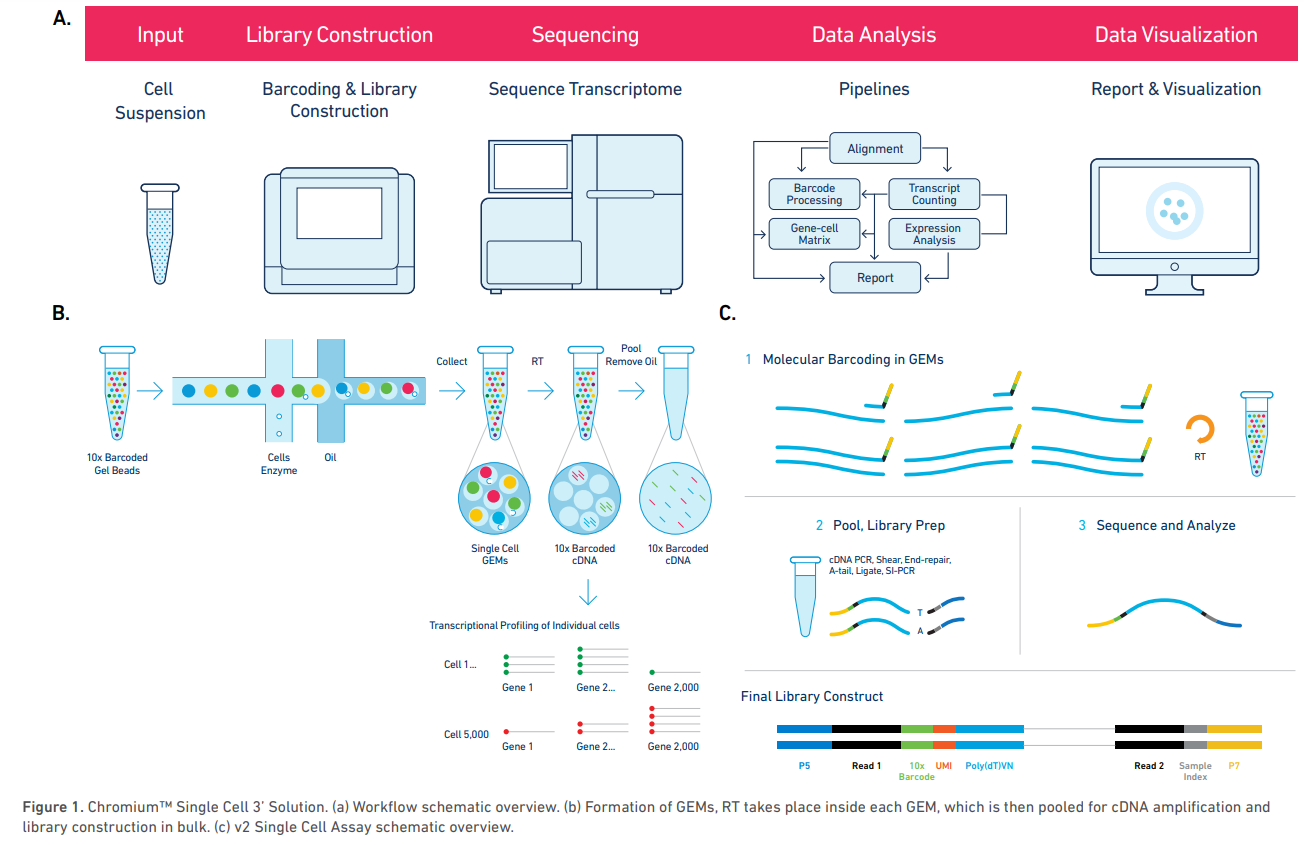

# **Dataset Overview: Human Organoids Study**

## **Data Description**
In this analysis, we will work with **human organoid** data obtained from the **GEO database**. The dataset provides transcriptomic information from **wild-type (WT) human organoids**, allowing us to study gene expression patterns and network interactions.

## **Dataset Details**
| **Attribute** | **Details** |
|--------------|------------|
| **Source Name** | Human organoids |
| **Organism** | *Homo sapiens* |
| **Characteristics** | Tissue: Human organoids |
|  | Genotype: Wild-type (WT) |

This dataset is available from the **GEO repository** at the following link:  
[**GSM7732411 - GEO Accession**](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM7732411)

## **Objective of the Analysis**
- Explore **gene expression patterns** in human organoids.  
- Examine how QC affects clustering
-

This study provides insights into **wild-type human organoids**, which serve as a model for understanding **cellular differentiation, disease mechanisms, and therapeutic applications**.

# Dependencies

In [1]:
pip install --upgrade scanpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 7.1 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=1297b9951b389c872a206edbff88a789192b9d43336107ce7b477a33f4083b97
  Stored in directory: /root/.cache/pip/wheels/4e/56/35/a748fc57279a4b84d0b332879445fed1ad8478e7257986b015
Successfully built session-info


In [7]:
# Core scverse libraries
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

# Core scverse libraries
import scanpy as sc
import anndata as ad

# Data retrieval
import pooch

In [26]:
# Locating you working directory
!pwd

/content


# Data Preprocessing

<img src="https://raw.githubusercontent.com/scverse/anndata/main/docs/_static/img/anndata_schema.svg" width="500" height="500">

This is the architecture of Anndata object, which is the core of `Scanpy`/`scverse` analysis of single-cell datasets.

# **Quick Notes on AnnData Format**

## **What is AnnData?**
AnnData (`anndata.AnnData`) is a data structure optimized for **single-cell omics** analysis, storing gene expression data along with metadata.

## **Main Components**
- **`.X`** → The main data matrix (sparse or dense), usually UMI counts or normalized expression.
- **`.obs`** → Cell metadata (e.g., `cell_type`, `batch`, `total_counts`).
- **`.var`** → Gene metadata (e.g., `gene_symbols`, `highly_variable`).
- **`.obsm`** → Embeddings (e.g., `X_pca`, `X_umap`).
- **`.uns`** → Unstructured data (e.g., clustering results, visualization settings).
- **`.layers`** → Alternative data representations (e.g., `raw`, `log1p`, `scaled`).

## **Example: Loading and Inspecting AnnData**
```python
import scanpy as sc

adata = sc.read_h5ad("dataset.h5ad")  # Load an AnnData file
print(adata)  # Quick overview
print(adata.obs.head())  # Check cell metadata
print(adata.var.head())  # Check gene metadata


# **Essential Components for Assembling an AnnData Object in Scanpy**

## **1. Core Data Matrices**
- **`.X`** → The primary data matrix (usually UMI counts or normalized expression values).
- **`adata.layers["counts"]`** → Stores raw counts separately from normalized data.
- **`adata.raw`** → Preserves raw untransformed data before normalization or log transformation.

## **2. Gene and Cell Metadata**
- **`adata.var`** → Contains gene-level metadata (e.g., gene names, feature selection).
  - Example columns: `gene_ids`, `highly_variable`, `mt_gene`
- **`adata.obs`** → Contains cell-level metadata (e.g., sample ID, clustering labels).
  - Example columns: `cell_type`, `patient_id`, `n_genes_by_counts`, `percent_mito`

## **3. Quality Control Metrics**
- **`n_genes_by_counts`** → Number of detected genes per cell.
- **`total_counts`** → Total UMI counts per cell.
- **`pct_counts_mt`** → Percentage of mitochondrial reads (indicator of cell stress).

## **4. Dimensionality Reduction and Embeddings**
- **`adata.obsm["X_pca"]`** → Principal Component Analysis (PCA) embedding.
- **`adata.obsm["X_umap"]`** → Uniform Manifold Approximation and Projection (UMAP) embedding.
- **`adata.obsm["X_tsne"]`** → t-SNE embedding.

## **5. Clustering and Cell Annotations**
- **`adata.obs["leiden"]`** → Leiden clustering labels.
- **`adata.obs["louvain"]`** → Louvain clustering labels.
- **`adata.obs["cell_type"]`** → Manual or automated cell type annotations.

## **6. Graph-Based Representations (for Clustering)**
- **`adata.obsp["distances"]`** → KNN graph distance matrix.
- **`adata.obsp["connectivities"]`** → Graph connectivities used in clustering.

## **7. Differential Expression Results**
- **`adata.uns["rank_genes_groups"]`** → Stores results from differential expression analysis (e.g., Wilcoxon test).
- **`adata.uns["log1p"]`** → Information on log-transformed data.

## **8. Storing Additional Layers**
- **`adata.layers["log1p"]`** → Log-transformed expression values.
- **`adata.layers["normalized"]`** → Total-count normalized values.
- **`adata.layers["scaled"]`** → Z-score scaled data for visualization.

---

### **Loading Data into AnnData**
#### **From 10X Genomics**
```python
import scanpy as sc

adata = sc.read_10x_mtx(
    "path/to/filtered_feature_bc_matrix/",
    var_names="gene_symbols",
    cache=True
)


## Loading in Scanpy

## PBMC

In [8]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [9]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

## Organoids

In [29]:
# Load data into Scanpy

In [30]:
# !pip install gdown

In [31]:
# # We download the necessary files for assembling the single-cell object from Google Drive which are in typical 10x format post-Cell Ranger
# !gdown --id 1cDTjLg7yn9ApH6YBClEz3cPNraFMVtWp -O organoids.tar.gz

In [32]:
# # Decompressing
# !tar -xzvf organoids.tar.gz

In [33]:
# # Path to the folder containing the matrix, barcodes, and genes files
# data_folder = "./organoids"

# # Load the data
# adata = sc.read_10x_mtx(
#     data_folder,       # Path to the folder containing the files
#     var_names='gene_symbols',  # Use gene symbols for variable names
#     cache=True         # Cache the result for faster reloading
# )

# # Inspect the loaded data
# print(adata)

# Quality Control (QC)

## Importance of Quality Control in Single-Cell Analysis

## Introduction
Single-cell RNA sequencing (scRNA-seq) has revolutionized our ability to study cellular heterogeneity and transcriptional dynamics at an unprecedented resolution. However, the high sensitivity of this technique makes it particularly susceptible to technical noise and artifacts. Quality control (QC) is a critical step in single-cell analysis to ensure reliable and biologically meaningful results.

## Key Reasons for Quality Control

### 1. **Removal of Low-Quality Cells**
- Some cells may have low RNA content or be damaged during sample preparation, leading to incomplete transcriptomes.
- Cells with an unusually high percentage of mitochondrial reads indicate potential cell stress or apoptosis.
- Filtering out low-quality cells improves downstream clustering and differential expression analyses.

### 2. **Mitigating Technical Artifacts**
- Doublets (two or more cells captured in a single droplet) can artificially inflate gene expression levels.
- Ambient RNA contamination can introduce misleading transcripts into cell profiles.
- Normalization and batch correction techniques help reduce unwanted technical variation.

### 3. **Ensuring Accurate Cell-Type Identification**
- Cells with insufficient feature counts or high dropout rates can distort clustering and cell annotation.
- Proper QC ensures that the final dataset reflects true biological heterogeneity rather than sequencing artifacts.

### 4. **Enhancing Reproducibility and Comparability**
- Poor-quality data can lead to irreproducible results that fail validation in independent experiments.
- QC allows for standardization across datasets, improving comparability in large-scale studies or meta-analyses.

### 5. **Optimizing Computational Performance**
- Retaining only high-quality cells reduces computational costs and prevents downstream analyses from being overwhelmed by noisy data.
- Streamlining datasets ensures more accurate and efficient clustering, trajectory inference, and gene regulatory network modeling.

## Common Quality Control Metrics

| Metric               | Description                                       | Common Thresholds |
|----------------------|-------------------------------------------------|-------------------|
| **Library Size**     | Total number of detected reads per cell         | Remove extreme outliers |
| **Feature Count**    | Number of unique genes detected per cell       | Filter cells with too few genes (< 500) |
| **Mitochondrial Content** | Percentage of mitochondrial reads          | Typically < 10% |
| **Doublet Score**    | Predicted probability of a cell being a doublet | Remove high-score doublets |
| **UMI Count**        | Number of unique molecular identifiers per cell | Normalize across cells |

## Conclusion
Quality control is an indispensable step in single-cell analysis to ensure that data reflects true biological variation rather than technical noise. Implementing stringent QC procedures improves the accuracy, reproducibility, and interpretability of single-cell studies, ultimately leading to more robust biological insights.

---

### Further Reading
- Luecken & Theis, 2019. *Current best practices in single-cell RNA-seq analysis*.
- Ilicic et al., 2016. *Classification of low-quality cells in single-cell RNA-seq data*.
- Andrews & Hemberg, 2018. *Identifying cell populations with scRNA-seq*.


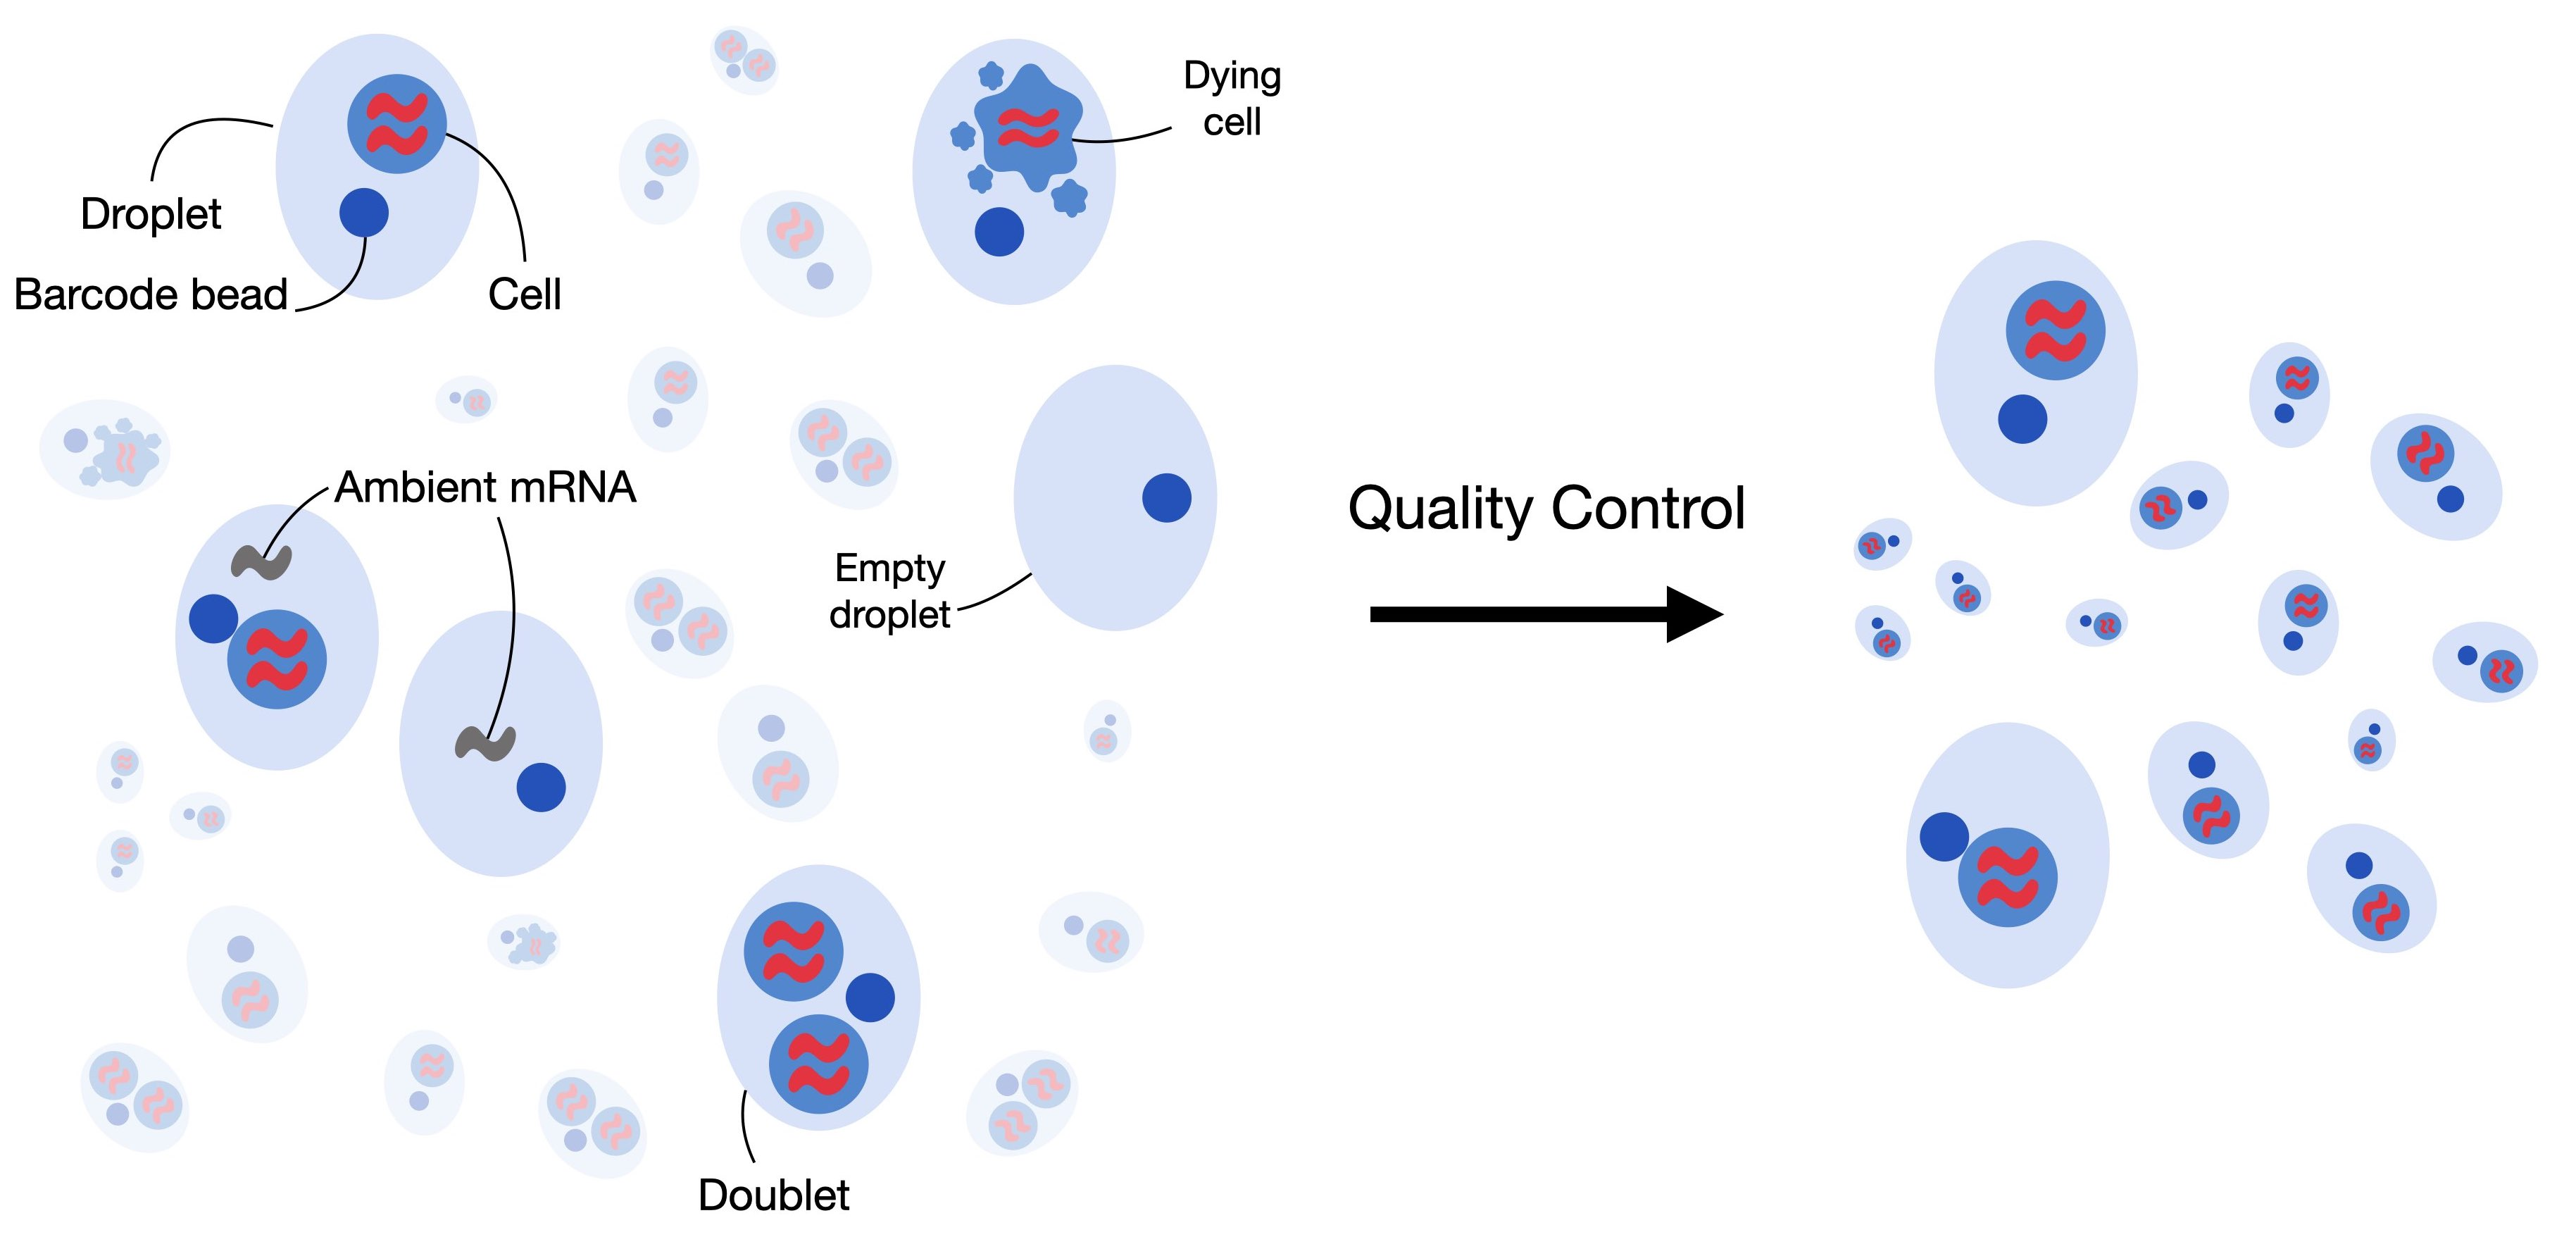

Single-cell RNA-seq datasets can contain low-quality cells, cell-free RNA and doublets. Quality control aims to remove and correct for those to obtain a high-quality dataset where each observation is an intact single cell

In [10]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [11]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

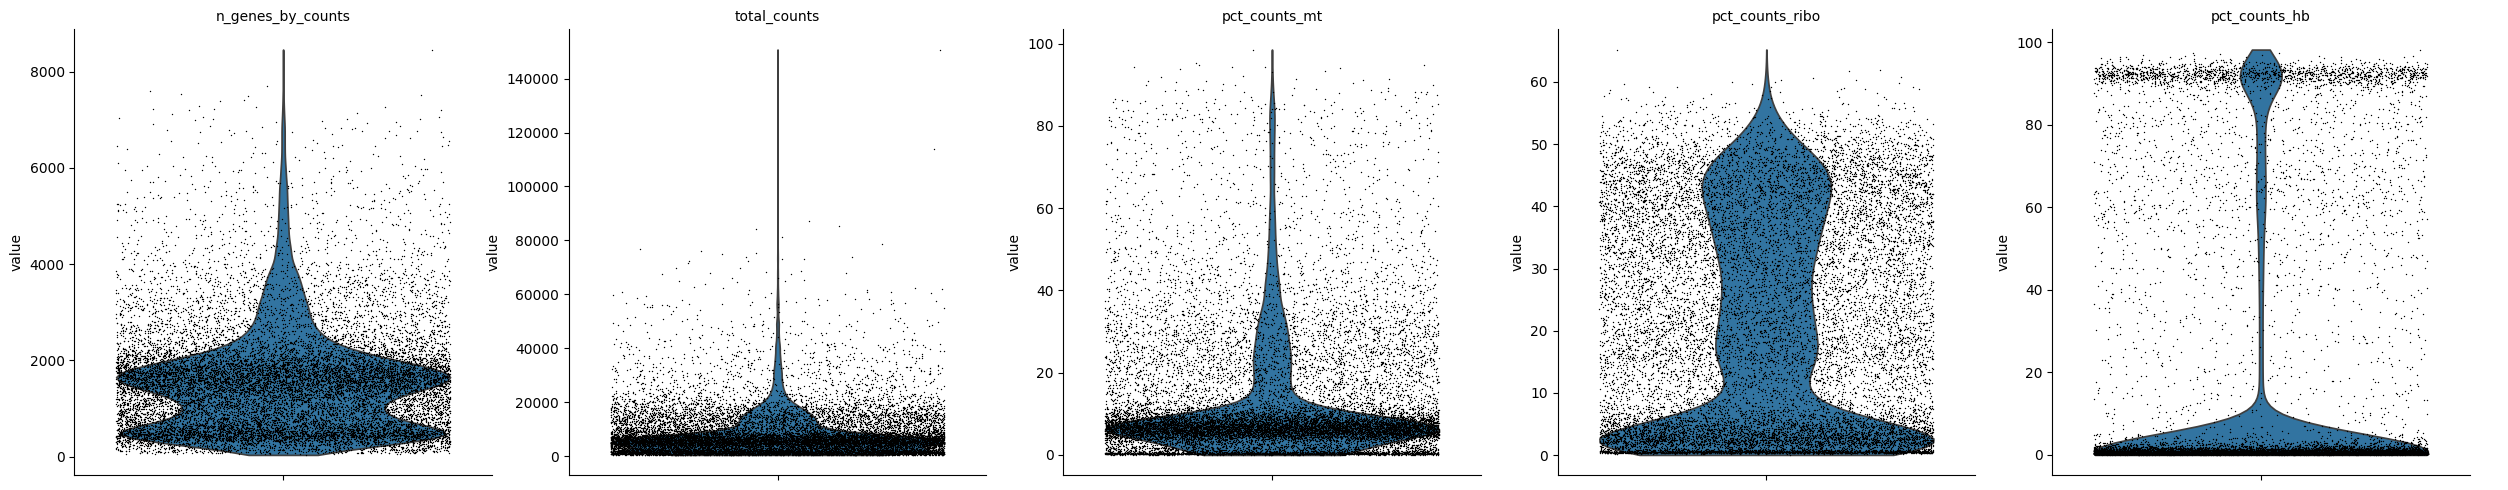

In [7]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    multi_panel=True,
)

Some additional metrics to consider are ribosomal and HB gene content, here is why:

| **Feature**           | **Why QC?**                                                              | **Action**                                |
|----------------------|-------------------------------------------------------------------------|-------------------------------------------|
| **Ribosomal Genes (rRNA)** | High expression may indicate technical biases, poor poly-A selection, or stressed cells. | Remove cells with **`pct_ribo > 20%`**   |
| **Hemoglobin Genes (HB)**  | High expression in non-erythroid cells suggests RBC contamination or lysis inefficiency. | Remove cells with **`pct_hb > 5-10%`** (unless working with blood samples) |


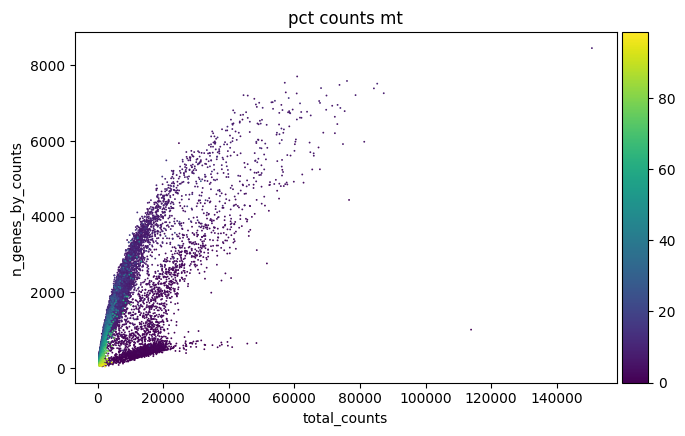

In [12]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

**What is this relationship telling us?**

The analyst usually decides filtering, but automated methods for QC are appearing on the horizon.

In [13]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

In [9]:
adata = adata[adata.obs.n_genes_by_counts < 2000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :].copy()

In [ ]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    multi_panel=True,
)

## Doublet detection

### **Why is Doublet Detection Important in Single-Cell RNA-Seq?**  

### **1. Prevents Artificial Cell States**  
- Doublets (two cells captured in one droplet) **mimic hybrid transcriptomes**, leading to false cell states.  

### **2. Improves Clustering Accuracy**  
- Doublets **distort clustering** by introducing mixed cell identities, affecting downstream analyses.  

### **3. Avoids Misleading Differential Expression (DE) Analysis**  
- Artificial gene expression profiles can **skew DE results**, leading to incorrect biological interpretations.  

### **4. Essential for High Cell Recovery Protocols**  
- Higher cell loading increases **doublet formation (~5-10% in standard 10x runs, higher in high-throughput methods)**.  

### **5. Doublet Detection Methods**  
- **Experimental**: Use **multiplet rate estimates** based on cell loading density.  
- **Computational**: Use tools like **Scrublet, DoubletFinder, scDblFinder** to identify and filter doublets.  


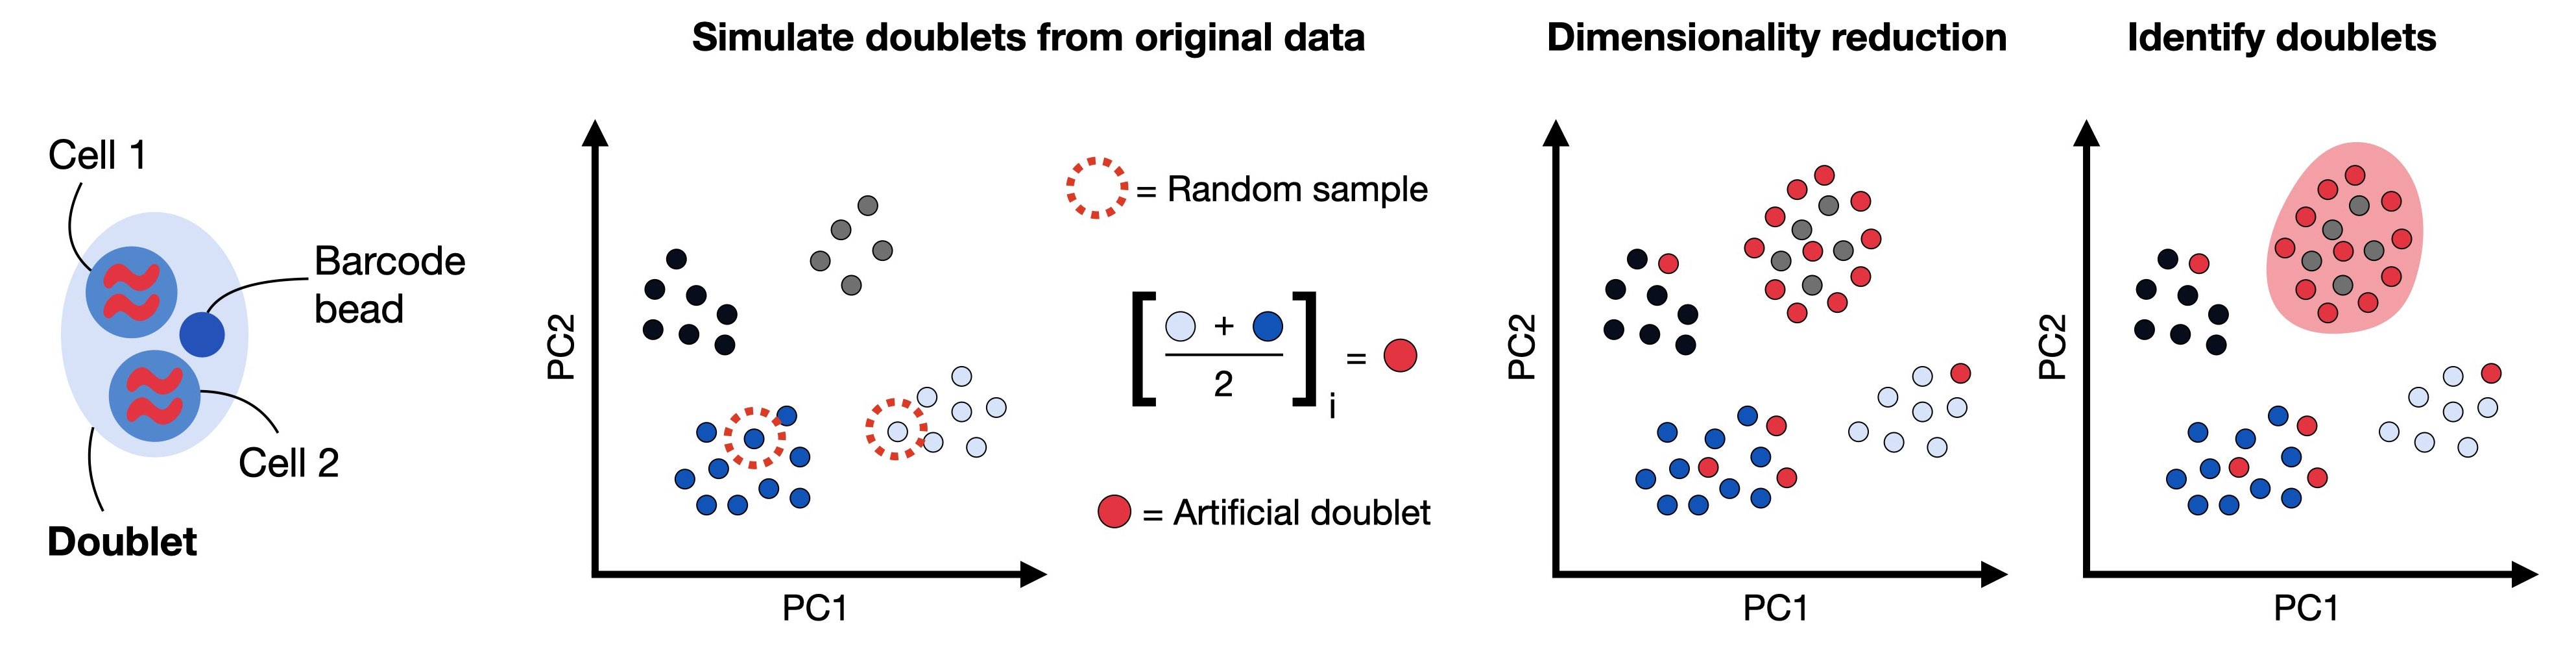

In [10]:
!pip install scikit-image

In [11]:
sc.pp.scrublet(adata)

In [12]:
adata = adata[~adata.obs["predicted_doublet"], :].copy()

# Normalisation

In [13]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [14]:
adata_backup = adata

In [15]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

# Feature Selection

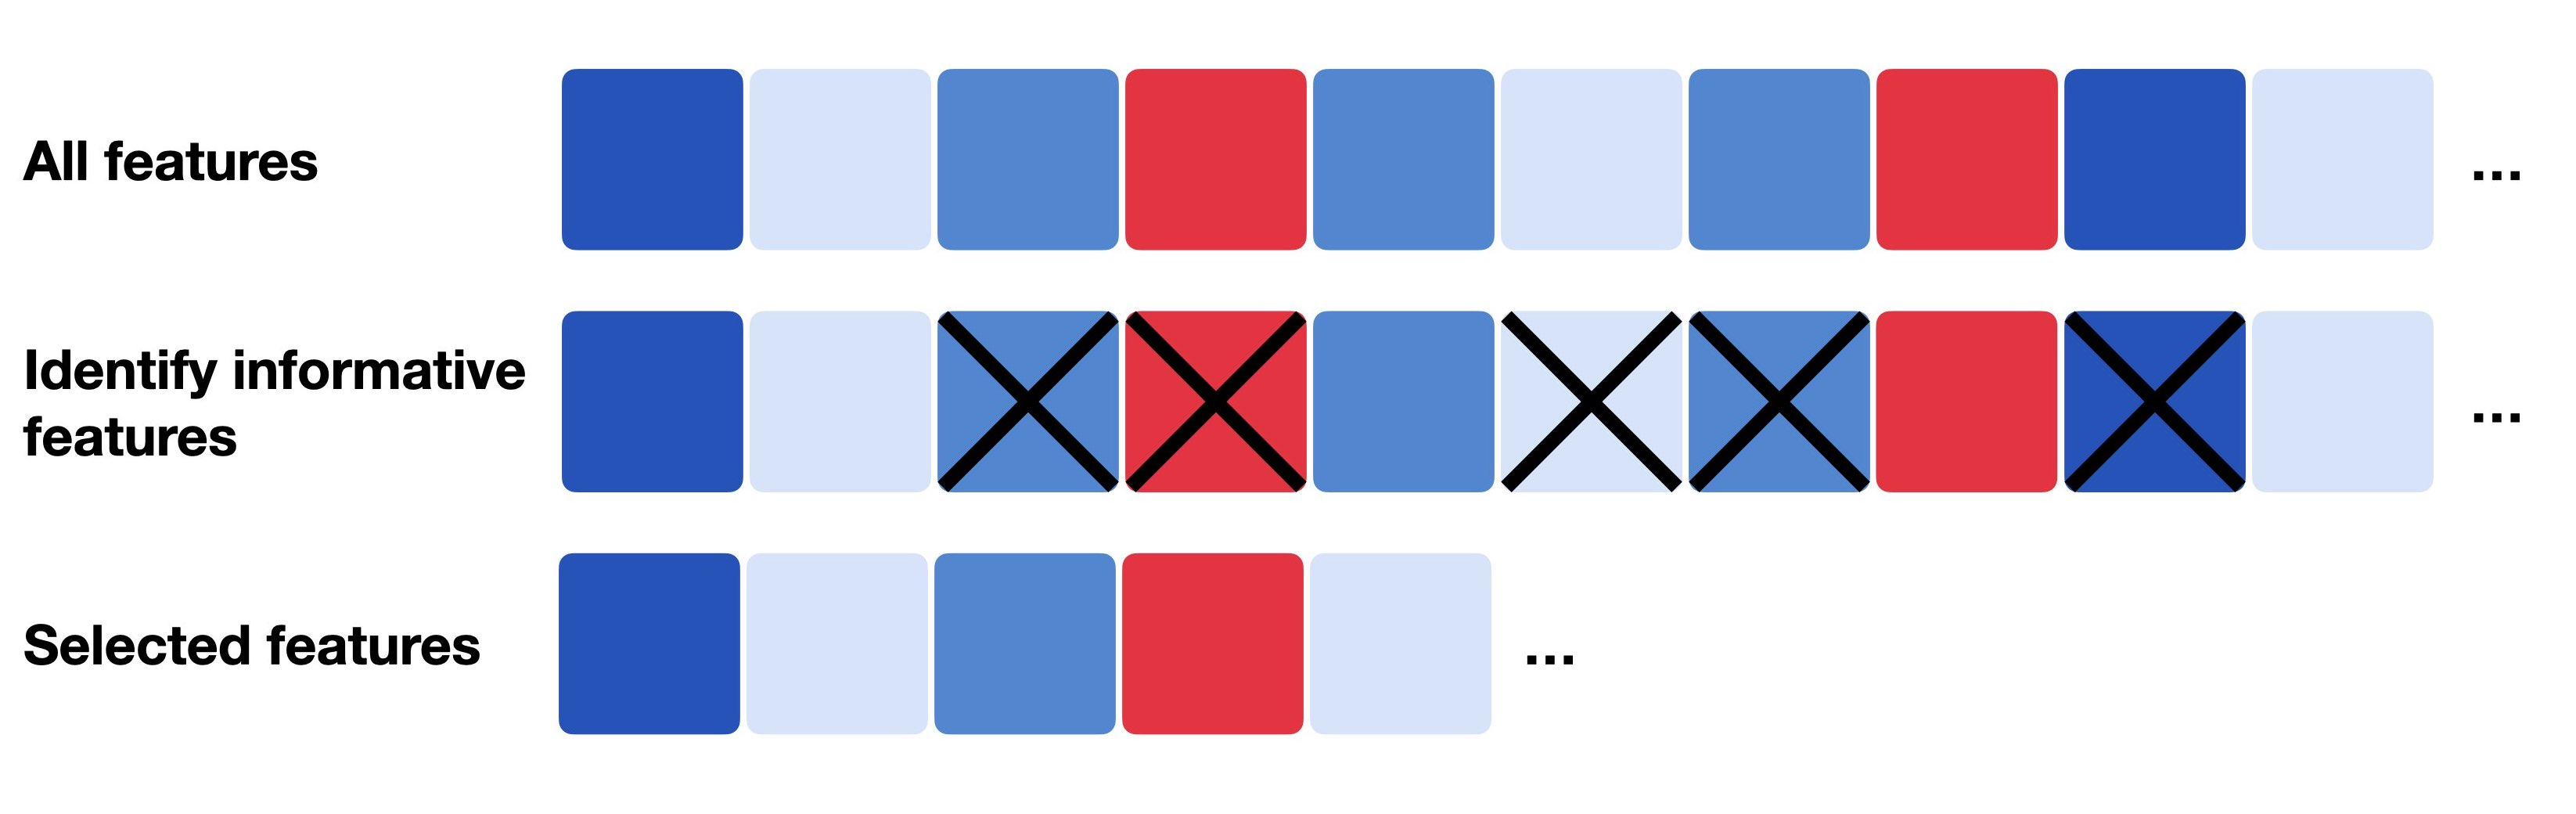

Feature selection generally describes the process of only selecting a subset of relevant features which can be the most informative, most variable or most deviant ones

In [16]:
sc.pp.highly_variable_genes(adata, n_top_genes=5000)

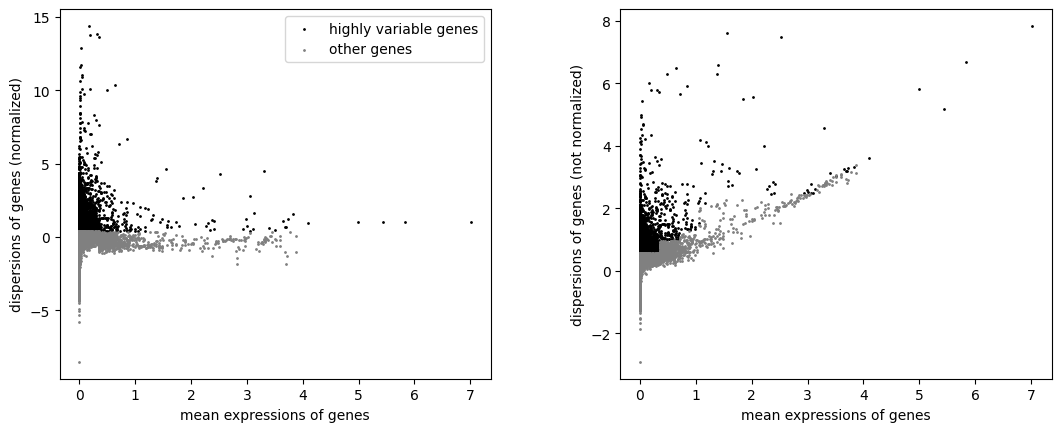

In [17]:
sc.pl.highly_variable_genes(adata)

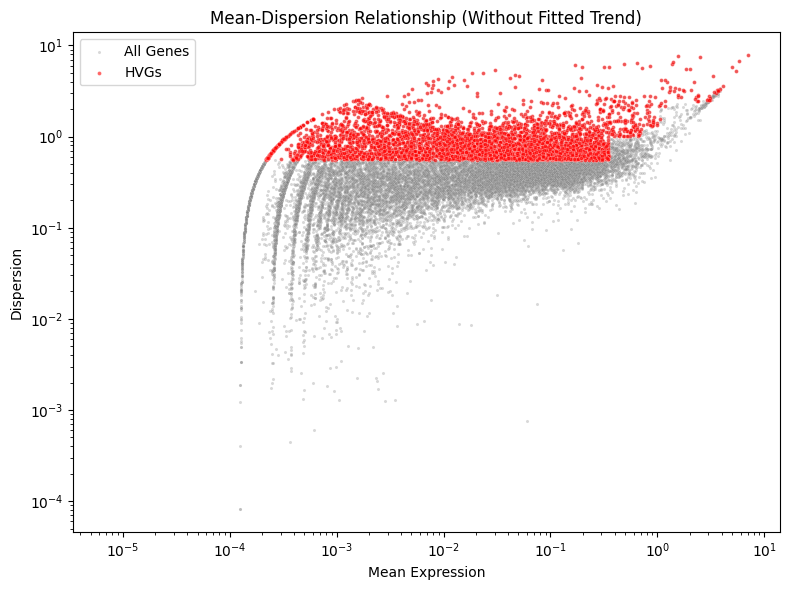

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract relevant data
mean = adata.var["means"]  # Mean expression per gene
dispersion = adata.var["dispersions"]  # Raw dispersion
hvg_mask = adata.var["highly_variable"]  # Boolean mask for HVGs

# Create figure
plt.figure(figsize=(8, 6))

# Scatter plot of all genes (light gray for visibility)
sns.scatterplot(x=mean, y=dispersion, s=5, alpha=0.3, label="All Genes", color="gray")

# Scatter plot of HVGs (highlighted in red, semi-transparent)
sns.scatterplot(x=mean[hvg_mask], y=dispersion[hvg_mask], color="red", s=8, alpha=0.6, label="HVGs")

# Set log-log scale
plt.xscale("log")
plt.yscale("log")

# Labels and title
plt.xlabel("Mean Expression")
plt.ylabel("Dispersion")
plt.title("Mean-Dispersion Relationship (Without Fitted Trend)")

# Display legend
plt.legend()
plt.tight_layout()
plt.show()


# Dimensionality Reduction

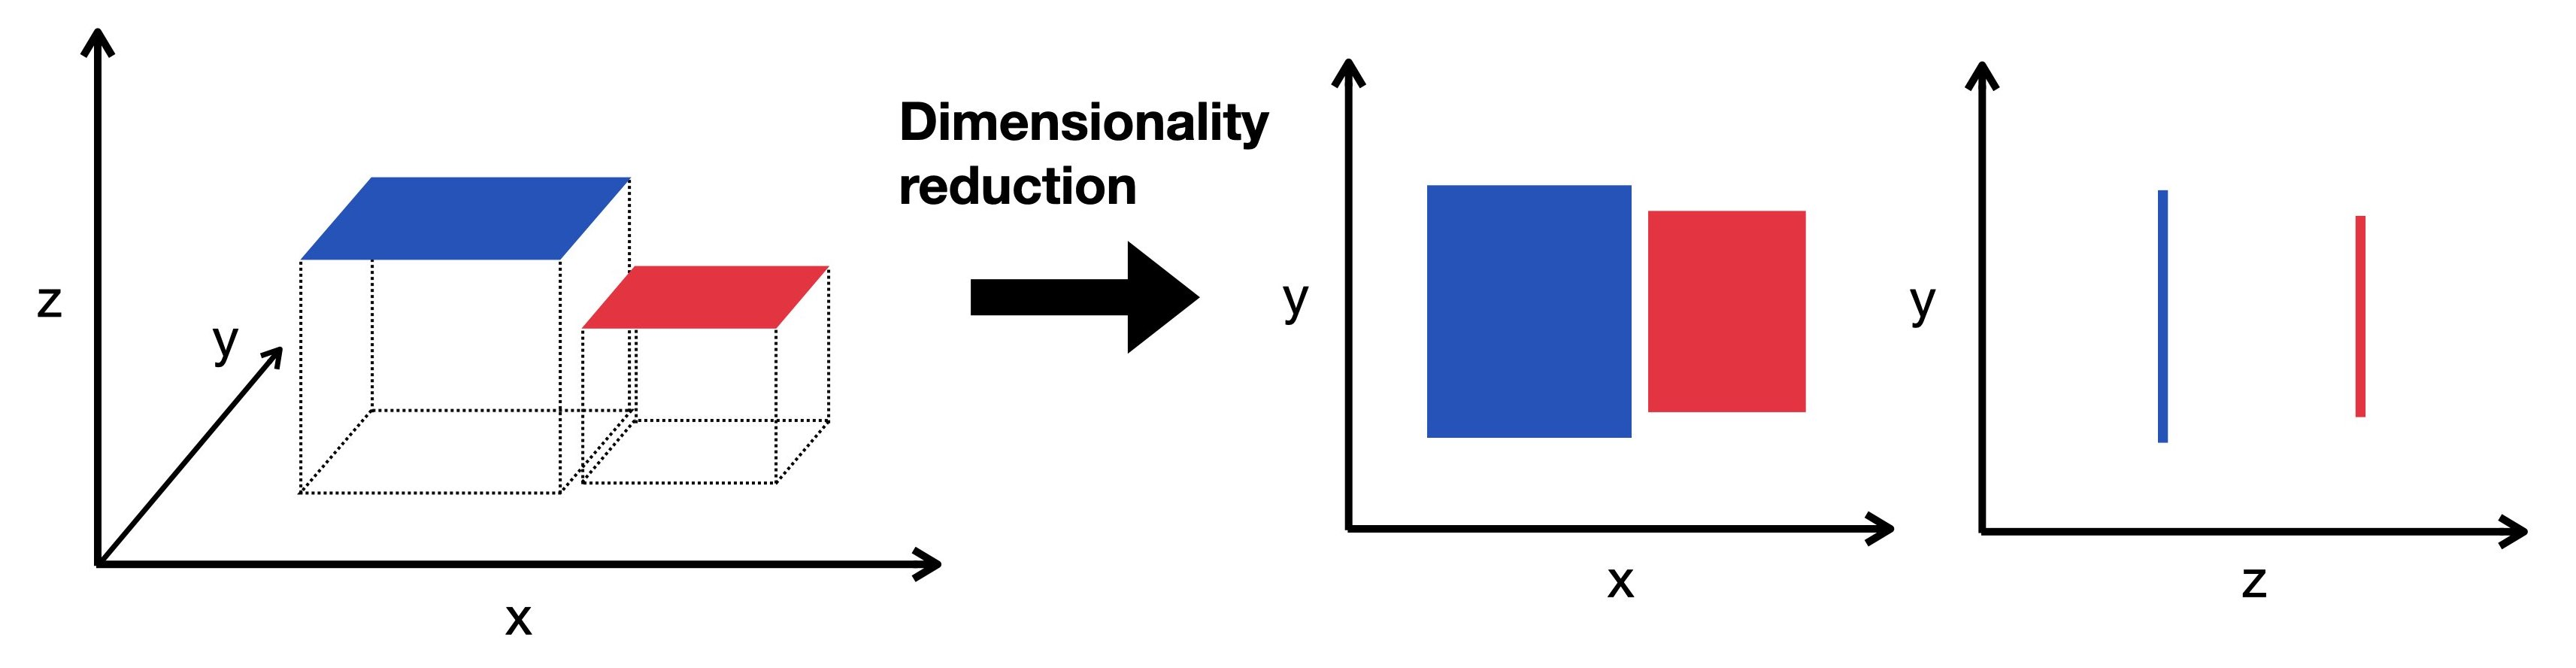

 Dimensionality reduction embeds the high-dimensional data into a lower dimensional space. The low-dimensional representation still captures the underlying structure of the data while having as few as possible dimensions. Here we visualize a three dimensional object projected into two dimensions.

In [21]:
sc.tl.pca(adata)

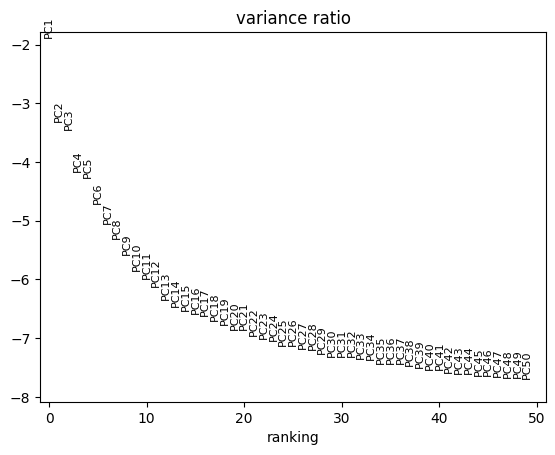

In [22]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

How can you select the appropriate number of PCs for the following steps? What happens if you select only 10 or 5?

# Nearest neighbor graph constuction, clustering and visualization

In [23]:
sc.pp.neighbors(adata)

In [24]:
sc.tl.umap(adata)

In [25]:
!pip3 install igraph
!pip3 install leidenalg

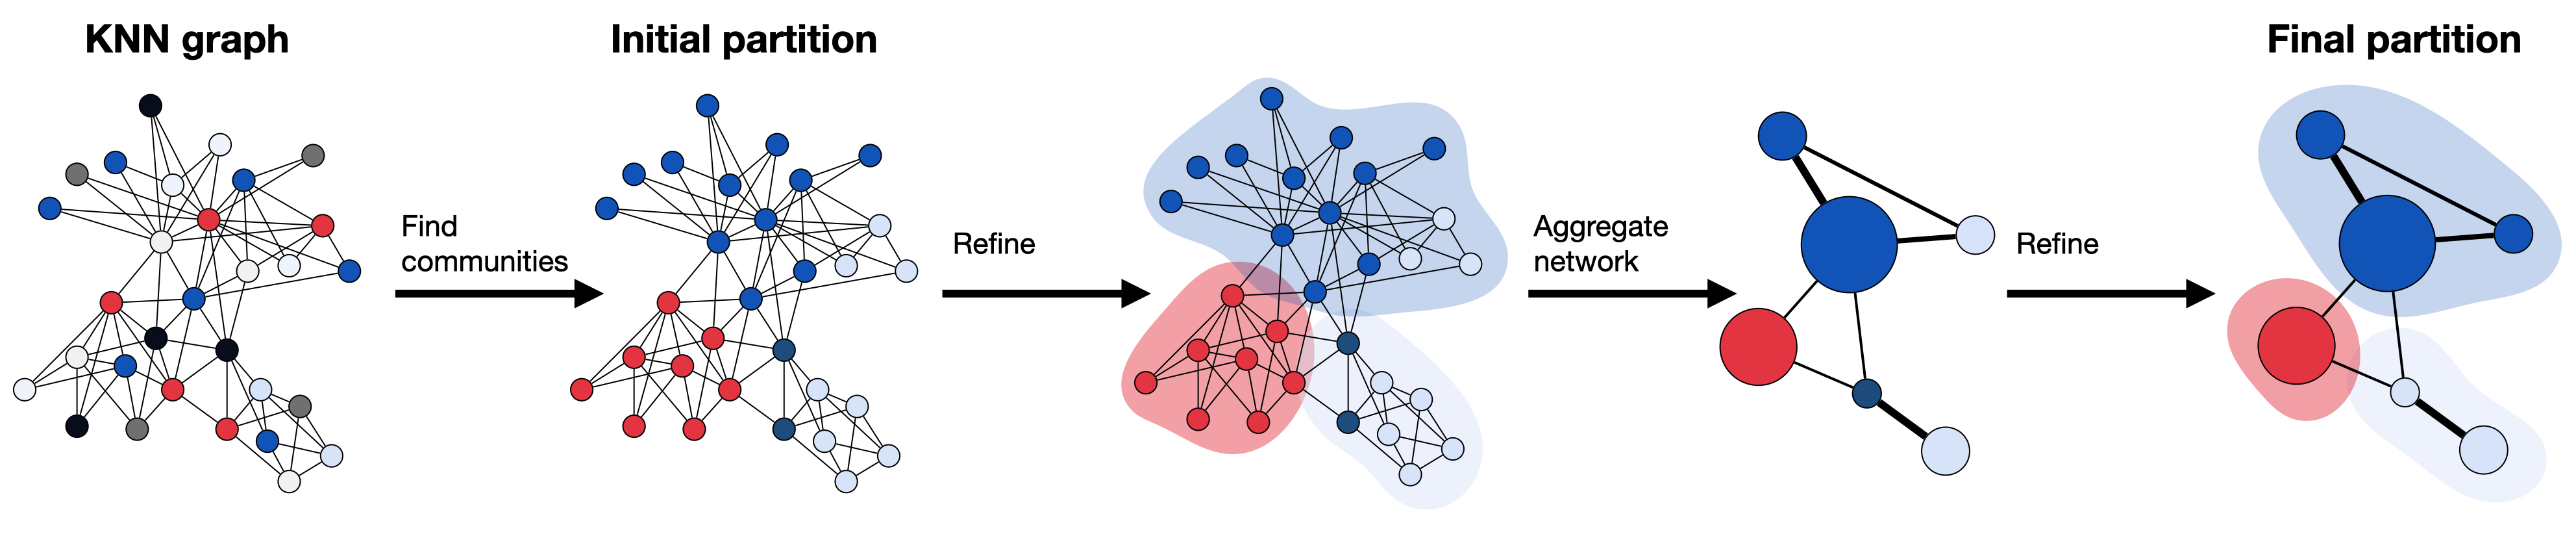

The Leiden algorithm computes a clustering on a KNN graph obtained from the PC reduced expression space. It starts with an initial partition where each node from its own community. Next, the algorithm moves single nodes from one community to another to find a partition, which is then refined. Based on a refined partition an aggregate network is generated, which is again refined until no further improvements can be obtained, and the final partition is reached

In [42]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.1)

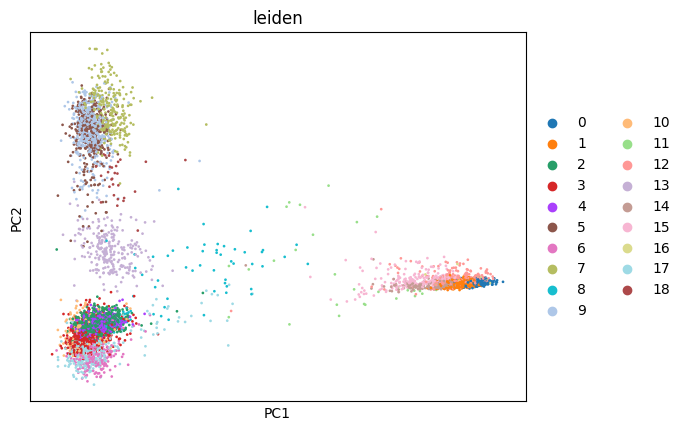

In [25]:
sc.pl.pca(adata, color = "leiden")

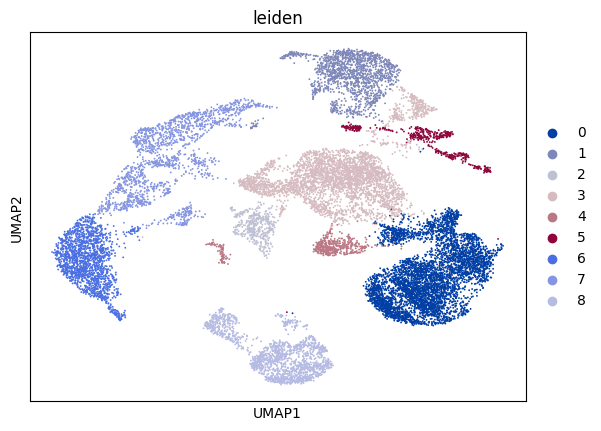

In [43]:
sc.pl.umap(adata, color=["leiden"])

❓**How can we change the number of clusters?**

❓**Why is PCA different than UMAP?**

❓**Where would you study trajectory pseudotime?**

# Marker genes

We are going to perform differential analysis in the concept of "one-vs-rest"
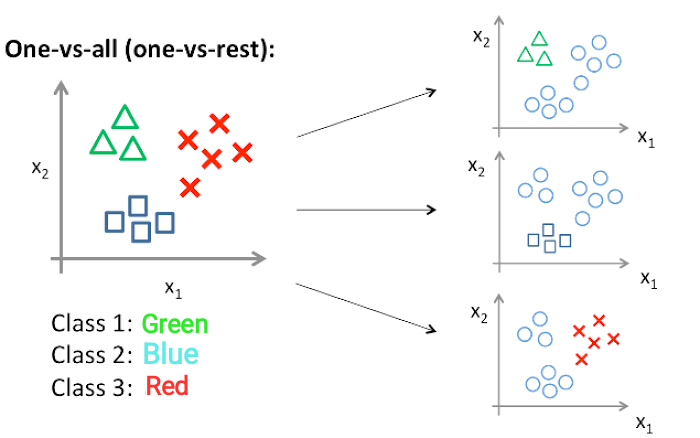

In [ ]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

In [ ]:
# Obtain cluster-specific differentially expressed genes
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=5
)

In [ ]:
adata

In [ ]:
adata.var["highly_variable"]

In [ ]:
hvg_genes = adata.var.index[adata.var["highly_variable"]].tolist()
print(f"Number of highly variable genes: {len(hvg_genes)}")
print(hvg_genes[:10])  # Print first 10 HVGshvg = adata.var.index[adata.var["highly_variable"]].tolist()  # Boolean mask,

In [ ]:
adata_v1 = adata

# SCTransform and Pearson Residuals

Alternative normalisation and scaling can be provided by [SCTransform method](https://scanpy-tutorials.readthedocs.io/en/latest/tutorial_pearson_residuals.html). Let's explore how it can affect downstream processing.

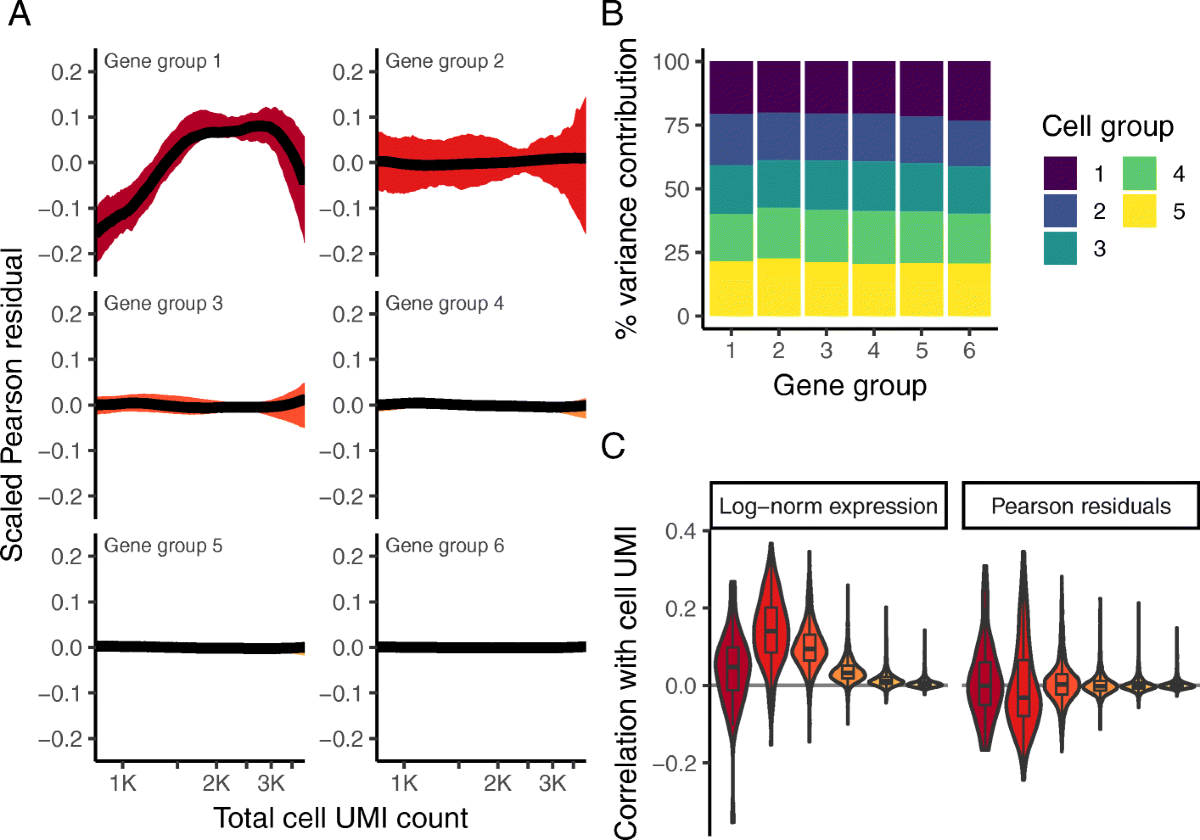

Pearson residuals transform raw UMI counts into a representation that achieves three key goals:

1. **Remove Technical Variation**  
   - Accounts for differences in total UMI counts across cells, reducing sequencing depth bias.  

2. **Stabilize the Mean-Variance Relationship**  
   - Ensures that both low and high-expression genes contribute meaningfully to downstream analyses.  

3. **Enhance Differential Expression Signal**  
   - Housekeeping genes (homogeneously expressed) have **low variance**, while marker genes (differentially expressed) have **high variance**.  

Thus, **computing Pearson residuals replaces the need for explicit sequencing-depth normalization and log-transformation** for variance stabilization.  

**Comparison to Seurat’s SCTransform**  
The analytic Pearson residuals used here are **conceptually similar** to Seurat’s **SCTransform model** (Hafemeister & Satija, 2019), but employ a **simplified model** that allows for an **analytic solution**.  

For more details, refer to **Lause et al. (2021)**.

In [ ]:
adata = adata_backup

In [ ]:
# import scanpy as sc

# # Define cell cycle gene lists from Tirosh et al. (2016)
# s_genes = [
#     "MCM5", "PCNA", "TYMS", "FEN1", "MCM2", "MCM4", "RRM1", "UNG", "GINS2", "MCM6",
#     "CDCA7", "DTL", "PRIM1", "UHRF1", "HELLS", "RFC2", "RPA2", "NASP", "RAD51AP1",
#     "GMNN", "WDR76", "SLBP", "CCNE2", "UBR7", "POLD3", "MSH2", "ATAD2", "RAD51",
#     "RRM2", "CDC45", "CDC6", "EXO1", "TIPIN", "DSCC1", "BLM", "CASP8AP2",
#     "USP1", "CLSPN", "POLA1", "CHAF1B", "BRIP1", "E2F8"
# ]

# g2m_genes = [
#     "HMGB2", "CDK1", "NUSAP1", "UBE2C", "BIRC5", "TPX2", "TOP2A", "NDC80",
#     "CKS2", "NUF2", "CKS1B", "MKI67", "TMPO", "CENPF", "TACC3", "FAM64A",
#     "SMC4", "CCNB2", "CKAP2L", "CKAP2", "AURKB", "BUB1", "KIF11", "ANLN",
#     "LBR", "CENPE", "CTCF", "G2E3", "GAS2L3", "NCAPG", "HJURP", "ESCO2",
#     "SGOL2", "PIMREG", "CDCA3", "HN1", "CDC20", "TTK", "CDC25C", "KIF20B",
#     "TFAP2C", "UBE2T"
# ]

# # Make sure genes are present in your dataset
# s_genes = [gene for gene in s_genes if gene in adata.var_names]
# g2m_genes = [gene for gene in g2m_genes if gene in adata.var_names]

# # Compute cell cycle scores
# sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

# # Check the computed cell cycle scores
# print(adata.obs[['S_score', 'G2M_score', 'phase']].head())

In [13]:
for adata in [adata]:
    sc.experimental.pp.highly_variable_genes(
        adata, flavor="pearson_residuals", n_top_genes=5000
    )

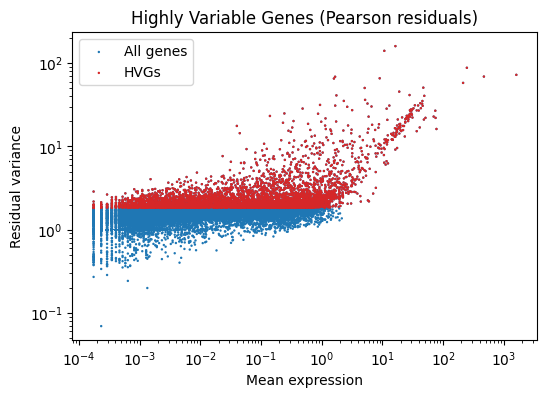

In [14]:
# Compute highly variable genes using Pearson residuals
for adata in [adata]:
    sc.experimental.pp.highly_variable_genes(
        adata, flavor="pearson_residuals", n_top_genes=5000
    )

# Extract data
mean_counts = adata.var["mean_counts"]
residual_variances = adata.var["residual_variances"]
hvgs = adata.var["highly_variable"]

# Create scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(mean_counts, residual_variances, s=3, edgecolor="none", label="All genes")
plt.scatter(mean_counts[hvgs], residual_variances[hvgs], c="tab:red", s=3, edgecolor="none", label="HVGs")

# Log scales & labels
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mean expression")
plt.ylabel("Residual variance")
plt.title("Highly Variable Genes (Pearson residuals)")
plt.legend()
plt.show()

In [15]:
import scanpy as sc
import numpy as np

# Store raw counts before normalization
adata.layers["raw"] = adata.X.copy()

# Apply total-count normalization and square-root transform
adata.layers["sqrt_norm"] = np.sqrt(sc.pp.normalize_total(adata, inplace=False)["X"])

# Print confirmation
print("Layers added: 'raw' (original counts), 'sqrt_norm' (sqrt-transformed normalized counts).")

Layers added: 'raw' (original counts), 'sqrt_norm' (sqrt-transformed normalized counts).


In [ ]:
 sc.experimental.pp.normalize_pearson_residuals(adata)

In [16]:
# try:
#     # Apply Pearson residual normalization
#     sc.experimental.pp.normalize_pearson_residuals(adata)

#     # Check for NaN values
#     if np.isnan(adata.X).sum() > 0:
#         raise ValueError("NaN values detected after Pearson residual normalization.")

# except (RuntimeWarning, ValueError, FloatingPointError) as e:
#     print(f"Warning: {e} - Applying gene filtering to handle zero-count genes.")

#     # Remove genes with zero counts before retrying normalization
#     sc.pp.filter_genes(adata, min_counts=1)

#     # Retry normalization
#     sc.experimental.pp.normalize_pearson_residuals(adata)

#     # Ensure no NaN values exist in the final result
#     adata.X = np.nan_to_num(adata.X)

# # Store the transformed data in a new layer
# adata.layers["pearson_residuals"] = adata.X.copy()

# print("Pearson residual normalization completed successfully!")

/usr/local/lib/python3.11/dist-packages/scanpy/experimental/pp/_normalization.py:70: RuntimeWarning: invalid value encountered in divide
  residuals = diff / np.sqrt(mu + mu**2 / theta)


/usr/local/lib/python3.11/dist-packages/scanpy/experimental/pp/_normalization.py:54: UserWarning: `normalize_pearson_residuals()` expects raw count data, but non-integers were found.
  warn(
/usr/local/lib/python3.11/dist-packages/scanpy/experimental/pp/_normalization.py:70: RuntimeWarning: invalid value encountered in sqrt
  residuals = diff / np.sqrt(mu + mu**2 / theta)


Pearson residual normalization completed successfully!


In [17]:
# Use Pearson residuals as the main data matrix for downstream analysis
adata.X = adata.layers["pearson_residuals"].copy()

In [ ]:
# sc.pp.regress_out(adata, ['S_score', 'G2M_score'])

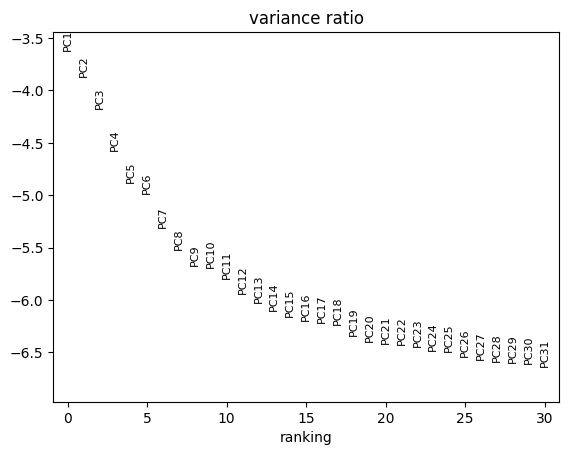

In [18]:
sc.pp.pca(adata)
sc.pl.pca_variance_ratio(adata, log=True)

In [19]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [20]:
sc.tl.umap(adata)

<ipython-input-23-24087c95b222>:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.25)  # Adjust resolution for granularity


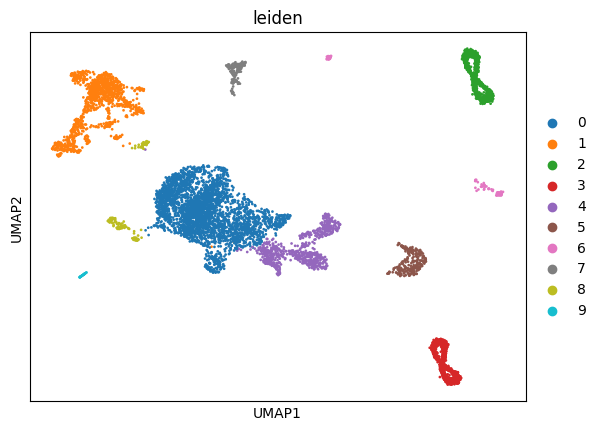

In [23]:
sc.tl.leiden(adata, resolution=0.25)  # Adjust resolution for granularity
sc.pl.umap(adata, color="leiden")  # Visualize clusters

In [ ]:
# import matplotlib.pyplot as plt
# import scipy.stats as stats
# import numpy as np
# import seaborn as sns

# # Define gene of interest (e.g., housekeeping or HVG)
# gene_of_interest = "GAPDH"  # Change this to analyze different genes

# # Ensure the gene exists in adata
# if gene_of_interest not in adata.var_names:
#     raise ValueError(f"Gene {gene_of_interest} not found in adata.var_names")

# # Extract residuals for this gene across all cells
# gene_index = np.where(adata.var_names == gene_of_interest)[0][0]
# gene_residuals = adata.layers["pearson_residuals"][:, gene_index]

# # Extract Leiden cluster labels for each cell
# if "leiden" not in adata.obs.columns:
#     raise ValueError("Leiden clustering has not been computed in adata.obs")

# cluster_labels = adata.obs["leiden"].astype(str)  # Convert to string for categorical coloring

# # Sort residuals to match quantile computation
# sorted_residuals = np.sort(gene_residuals)
# sorted_clusters = cluster_labels[np.argsort(gene_residuals)]  # Ensure clusters are sorted identically

# # Compute theoretical quantiles (normal distribution)
# theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(sorted_residuals)))

# # Assign colors to clusters
# unique_clusters = sorted_clusters.unique()
# cluster_colors = sns.color_palette("tab10", len(unique_clusters))
# cluster_color_map = dict(zip(unique_clusters, cluster_colors))
# colors = [cluster_color_map[label] for label in sorted_clusters]

# # Create Q-Q plot with Leiden clusters
# fig, ax = plt.subplots(figsize=(7, 7))
# ax.scatter(theoretical_quantiles, sorted_residuals, c=colors, alpha=0.8, edgecolors="black", s=15)

# # Plot normality line
# ax.plot(theoretical_quantiles, theoretical_quantiles, color="red", linestyle="dashed", label="Normality Line")

# # Labels and legend
# plt.title(f"Q-Q Plot of Pearson Residuals for {gene_of_interest} (Colored by Leiden Cluster)")
# plt.xlabel("Theoretical Quantiles (Normal Distribution)")
# plt.ylabel("Ordered Pearson Residuals")
# plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_color_map[c], markersize=8, label=f"Cluster {c}") for c in unique_clusters])
# plt.show()


In [ ]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

In [ ]:
sc.tl.dendrogram(adata, groupby="leiden")
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden", standard_scale="var", n_genes=5)

In [ ]:
hvg_genes_sct = adata.var.index[adata.var["highly_variable"]].tolist()
print(f"Number of highly variable genes: {len(hvg_genes_sct)}")
print(hvg_genes_sct[:10])  # Print first 10 HVGshvg = adata.var.index[adata.var["highly_variable"]].tolist()  # Boolean mask,

In [ ]:
common_hvg = list(set(hvg_genes_sct) & set(hvg_genes))
print(f"Number of common HVGs: {len(common_hvg)}")
print(common_hvg[:10])  # Show first 10 common genes

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Convert lists to sets
set_sct = set(hvg_genes_sct)
set_hvg = set(hvg_genes)

# Create Venn diagram
plt.figure(figsize=(5, 5))
venn2([set_sct, set_hvg], set_labels=("HVG Genes SCT", "HVG Genes"))

# Title
plt.title("Venn Diagram of Highly Variable Genes (HVG)")

# Show plot
plt.show()

# Comparing standard pipeline vs Pearson Residuals

## 1. Visualizing Raw vs. Normalized Expression

## Raw Counts

- The raw counts often exhibit large variability, with some genes having very high expression levels compared to others.
- This variability is visible in the violin plots, where some genes have broader distributions with higher medians.

## Square-root Normalization

- Applying the square root transformation reduces the influence of large outliers and compresses the dynamic range of the data.
- As a result, the distributions across genes become more similar, and the mean values appear closer together.
- This transformation preserves the relative differences between low- and high-expression values but makes the data less skewed.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set seed for reproducibility
np.random.seed(42)

# Ensure HVG exists
if "highly_variable" in adata.var.columns:
    hvg_genes = adata.var.index[adata.var["highly_variable"]].tolist()
else:
    hvg_genes = adata.var_names.tolist()

# Select 10 random highly variable genes
random_genes = np.random.choice(hvg_genes, 10, replace=False)

# Convert sparse matrix to dense and create DataFrame
raw_counts = pd.DataFrame(adata[:, random_genes].layers["raw"].toarray(), columns=random_genes)

# Plot raw counts
plt.figure(figsize=(12, 6))
sns.violinplot(data=raw_counts, inner="quartile")
plt.xticks(rotation=90)
plt.title("Raw Counts Distribution (10 Random Highly Variable Genes)")
plt.xlabel("Genes")
plt.ylabel("Raw Counts")
plt.show()

# Convert sparse matrix to dense for sqrt-normalized counts
sqrt_norm_counts = pd.DataFrame(adata[:, random_genes].layers["sqrt_norm"].toarray(), columns=random_genes)

# Plot sqrt-normalized counts
plt.figure(figsize=(12, 6))
sns.violinplot(data=sqrt_norm_counts, inner="quartile")
plt.xticks(rotation=90)
plt.title("Square-root Normalized Counts Distribution (10 Random Highly Variable Genes)")
plt.xlabel("Genes")
plt.ylabel("Normalized Counts (sqrt)")
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Check if mean expression exists in `adata.var`, otherwise compute it
if "vst.mean" in adata.var.columns:
    top_mean_genes = adata.var["vst.mean"].nlargest(10).index.tolist()
else:
    # Compute mean expression manually if not available
    mean_expression = adata.X.mean(axis=0).A1 if hasattr(adata.X, "A1") else adata.X.mean(axis=0)
    adata.var["mean_expression"] = mean_expression
    top_mean_genes = adata.var["mean_expression"].nlargest(10).index.tolist()

# Convert sparse matrix to dense and create DataFrame
raw_counts_top = pd.DataFrame(adata[:, top_mean_genes].layers["raw"].toarray(), columns=top_mean_genes)

# Plot raw counts for high mean expression genes
plt.figure(figsize=(12, 6))
sns.violinplot(data=raw_counts_top, inner="quartile")
plt.xticks(rotation=90)
plt.title("Raw Counts Distribution (Top 10 Genes by Mean Expression)")
plt.xlabel("Genes")
plt.ylabel("Raw Counts")
plt.show()

# Convert sparse matrix to dense for sqrt-normalized counts
sqrt_norm_counts_top = pd.DataFrame(adata[:, top_mean_genes].layers["sqrt_norm"].toarray(), columns=top_mean_genes)

# Plot sqrt-normalized counts
plt.figure(figsize=(12, 6))
sns.violinplot(data=sqrt_norm_counts_top, inner="quartile")
plt.xticks(rotation=90)
plt.title("Square-root Normalized Counts Distribution (Top 10 Genes by Mean Expression)")
plt.xlabel("Genes")
plt.ylabel("Normalized Counts (sqrt)")
plt.show()


## 2. Mean-Variance Relationship Before & After Normalization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 📌 Convert sparse matrices to dense only if necessary
X_raw = adata.layers["raw"]
X_sqrt = adata.layers["sqrt_norm"]
X_pearson = adata.layers["pearson_residuals"]

if hasattr(X_raw, "toarray"):  # Check if it's sparse
    X_raw = X_raw.toarray()
if hasattr(X_sqrt, "toarray"):
    X_sqrt = X_sqrt.toarray()
if hasattr(X_pearson, "toarray"):
    X_pearson = X_pearson.toarray()

# 📌 Compute mean and variance
adata.var["mean_raw"] = np.mean(X_raw, axis=0)
adata.var["var_raw"] = np.var(X_raw, axis=0)

adata.var["mean_sqrt"] = np.mean(X_sqrt, axis=0)
adata.var["var_sqrt"] = np.var(X_sqrt, axis=0)

adata.var["mean_pearson"] = np.mean(X_pearson, axis=0)
adata.var["var_pearson"] = np.var(X_pearson, axis=0)

# 📌 Scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, mean, var, title in zip(
    axes,
    ["mean_raw", "mean_sqrt", "mean_pearson"],
    ["var_raw", "var_sqrt", "var_pearson"],
    ["Raw Counts", "Square-root Normalized", "Pearson Residuals"]
):
    ax.scatter(adata.var[mean], adata.var[var], s=3, alpha=0.5)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"Mean-Variance Relationship ({title})")
    ax.set_xlabel("Mean expression")
    ax.set_ylabel("Variance")

plt.tight_layout()
plt.show()

### **Mean-Variance Relationship Plots: Interpretation**

The plots compare the relationship between the **mean expression** and the **variance** of genes across three data transformations:

1. **Raw Counts**
2. **Square-root Normalized Counts**
3. **Pearson Residuals**

---

## **1️⃣ Raw Counts**
- **Trend:** Variance increases with the mean expression.
- **Key Observations:**
  - Highly expressed genes exhibit higher variability.
  - Lowly expressed genes show low variance but may be dominated by dropout effects.
- **Why it happens:** The raw count data is heavily affected by technical noise and biological variability, leading to strong **mean-variance dependency**.
- **Limitations:**
  - Not variance-stabilized.
  - Unsuitable for direct downstream analyses like clustering or differential expression.

---

## **2️⃣ Square-root Normalized Counts**
- **Trend:** The variance is reduced but still slightly dependent on the mean.
- **Key Observations:**
  - Square-root transformation compresses highly variable genes, making their variability less extreme.
  - Low-expression genes remain largely unaffected.
- **Why it happens:** Square-root normalization adjusts the scale of the data, reducing the impact of high expression values but does not fully remove systematic variance trends.
- **Strengths:**
  - Improves variance stabilization.
  - Useful for moderate adjustments.
- **Limitations:**
  - Still retains some mean-variance dependency, which may bias downstream results.

---

## **3️⃣ Pearson Residuals**
- **Trend:** Variance is independent of the mean, centered around **variance = 1**.
- **Key Observations:**
  - Most genes have residual variance ≈ 1, which corresponds to the null model (no biological variability).
  - Genes with **residual variance > 1** deviate from the null model and may represent **highly variable genes (HVGs)**.
- **Why it happens:** Pearson residuals are calculated by subtracting expected counts (null model) from observed counts and scaling by their standard deviation, stabilizing variance.
- **Strengths:**
  - Fully variance-stabilized.
  - Highlights **biologically variable genes**.
- **Use Case:**
  - Identify HVGs for clustering, differential expression, or pathway analysis.

---

### **Key Takeaways**
- **Raw Counts:** Strong mean-variance dependency; not ideal for direct use.
- **Square-root Normalized Counts:** Partially stabilizes variance but retains dependency.
- **Pearson Residuals:** Achieves full variance stabilization and highlights biologically meaningful variability.

---

### **Additional Notes**
- Pearson residuals are particularly useful in identifying genes that deviate significantly from technical noise, making them suitable for **unsupervised analyses**.
- This approach is commonly recommended for scRNA-seq preprocessing because it ensures robust downstream results.


## 3. Residual Variance vs. Mean Expression (Pearson Residuals)

In [ ]:
# Extract mean and residual variances
mean_counts = adata.var["mean_counts"]
residual_variances = adata.var["residual_variances"]
hvgs = adata.var["highly_variable"]

# Scatter plot of residual variance vs. mean expression
plt.figure(figsize=(6, 4))
plt.scatter(mean_counts, residual_variances, s=3, edgecolor="none", label="All genes")
plt.scatter(mean_counts[hvgs], residual_variances[hvgs], c="tab:red", s=3, edgecolor="none", label="HVGs")

# Add reference line (expected variance = 1)
plt.axhline(y=1, color="black", linestyle="--", label="Null Model Variance = 1")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mean expression")
plt.ylabel("Residual variance")
plt.title("Highly Variable Genes (Pearson Residuals)")
plt.legend()
plt.show()

 **Q-Q Plots in Single-Cell Analysis**

**What is a Q-Q Plot?**
A **Quantile-Quantile (Q-Q) plot** is a statistical tool used to **compare the distribution of observed data** against a **theoretical normal distribution**. It helps us assess whether data follows normality or deviates due to **skewness, overdispersion, or outliers**.

In **single-cell RNA-seq analysis**, Q-Q plots are particularly useful when examining **Pearson residuals** after variance stabilization. They help visualize which genes exhibit expected variability and which deviate significantly.

---

**How to Interpret a Q-Q Plot?**
Each **dot** in the Q-Q plot represents a **residual value for a gene across cells**. The interpretation depends on how these dots align with the **red diagonal line** (the normality reference):

| **Pattern** | **Interpretation** | **Example in scRNA-seq** |
|------------|------------------|-------------------------|
| **Dots align with the red line** | Residuals follow a normal distribution | Housekeeping genes (low variance) |
| **Right tail curves upward** | Right-skewed distribution, overdispersion | Highly variable genes (HVGs) |
| **Left tail curves downward** | Left-skewed distribution, underdispersion | Lowly expressed genes |
| **S-shaped curve** | Non-normal distribution | Potential batch effects or biological variability |

---

**Q-Q Plots in Pearson Residual Analysis**
- In **housekeeping genes**, residuals are **normally distributed** (points align with the red line).
- In **highly variable genes (HVGs)**, residuals show **large deviations in the upper tail**, indicating **high variability** in specific cells.
- In **Leiden cluster-colored Q-Q plots**, we can check if **certain clusters systematically deviate**, suggesting **biological significance**.

---

**Why Are Q-Q Plots Useful in Single-Cell RNA-Seq?**
- ✅ **Detects overdispersed genes** (important for differential expression).
- ✅ **Identifies batch effects** that may cause skewed distributions.
- ✅ **Helps validate variance stabilization** methods like Pearson residuals.
- ✅ **Reveals biological variability** across different cell populations.

By combining **Q-Q plots with histograms**, we can further **visualize gene-specific deviations** from normality, making them an essential tool in **single-cell quality control and downstream analysis**.

---

**Example: Q-Q Plot of Housekeeping vs. Highly Variable Genes**
Below is an example of a Q-Q plot comparing **housekeeping genes (GAPDH, ACTB, etc.)** vs. **HVGs**:

- 🔵 **Housekeeping genes** → Points follow the **red diagonal** closely.
- 🔴 **HVGs** → Points deviate in the **upper tail**, showing overdispersion.



In [ ]:
# Downsample if needed for faster plotting
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

# Housekeeping genes commonly used in single-cell RNA-seq
housekeeping_genes = ["ACTB", "GAPDH", "B2M", "RPLP0", "RPL13A", "HPRT1", "EEF1A1", "UBC"]

# Get HVGs from adata
hvg_genes = adata.var.index[adata.var["highly_variable"]].tolist()

# Ensure Pearson residuals are correctly extracted per gene
residuals_matrix = adata.layers["pearson_residuals"]  # Keep matrix shape

# Extract residuals for housekeeping and HVG genes
housekeeping_mask = np.isin(adata.var_names, housekeeping_genes)
hvg_mask = np.isin(adata.var_names, hvg_genes)

# Flatten after filtering genes to avoid shape mismatch
housekeeping_residuals = residuals_matrix[:, housekeeping_mask].flatten()
hvg_residuals = residuals_matrix[:, hvg_mask].flatten()

# Downsample if too large
downsample_size = 50000  # Adjust this value if needed
if len(housekeeping_residuals) > downsample_size:
    housekeeping_residuals = np.random.choice(housekeeping_residuals, size=downsample_size, replace=False)

if len(hvg_residuals) > downsample_size:
    hvg_residuals = np.random.choice(hvg_residuals, size=downsample_size, replace=False)

# Create a DataFrame with labels for each residual type
df = pd.DataFrame({
    "Pearson Residual": np.concatenate([housekeeping_residuals, hvg_residuals]),
    "Gene Type": (["Housekeeping"] * len(housekeeping_residuals)) + (["HVGs"] * len(hvg_residuals))
})

# Histogram comparison
plt.figure(figsize=(7, 5))
sns.histplot(df, x="Pearson Residual", hue="Gene Type", bins=50, kde=True)
plt.xlabel("Pearson Residuals")
plt.ylabel("Frequency")
plt.title("Comparison of Housekeeping vs. Highly Variable Gene Residuals (Downsampled)")
plt.show()

# Q-Q Plot for Housekeeping Genes
fig, ax = plt.subplots(figsize=(6, 6))
stats.probplot(housekeeping_residuals, dist="norm", plot=ax)
plt.title("Q-Q Plot of Housekeeping Gene Residuals (Downsampled)")
plt.show()

# Q-Q Plot for HVGs
fig, ax = plt.subplots(figsize=(6, 6))
stats.probplot(hvg_residuals, dist="norm", plot=ax)
plt.title("Q-Q Plot of Highly Variable Gene Residuals (Downsampled)")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Define housekeeping genes
housekeeping_genes = ["ACTB", "GAPDH", "B2M", "RPLP0", "RPL13A", "HPRT1", "EEF1A1", "UBC"]

# Ensure selected genes exist in adata
valid_genes = [gene for gene in housekeeping_genes if gene in adata.var_names]

if not valid_genes:
    raise ValueError("None of the housekeeping genes were found in adata.var_names.")

# Create separate Q-Q plots for each housekeeping gene
for gene in valid_genes:
    gene_index = np.where(adata.var_names == gene)[0][0]
    gene_residuals = adata.layers["pearson_residuals"][:, gene_index]

    # Create Q-Q plot
    fig, ax = plt.subplots(figsize=(6, 6))
    stats.probplot(gene_residuals, dist="norm", plot=ax)
    plt.title(f"Q-Q Plot of Pearson Residuals for {gene}")
    plt.xlabel("Theoretical Quantiles (Normal Distribution)")
    plt.ylabel("Ordered Pearson Residuals")
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Select the top 5 highly variable genes (HVGs)
top_5_hvg = adata.var[adata.var["highly_variable"]].index[:5].tolist()

# Ensure selected genes exist in adata
valid_hvg = [gene for gene in top_5_hvg if gene in adata.var_names]

if not valid_hvg:
    raise ValueError("No highly variable genes found in adata.var_names.")

# Create separate Q-Q plots for each HVG
for gene in valid_hvg:
    gene_index = np.where(adata.var_names == gene)[0][0]
    gene_residuals = adata.layers["pearson_residuals"][:, gene_index]

    # Create Q-Q plot
    fig, ax = plt.subplots(figsize=(6, 6))
    stats.probplot(gene_residuals, dist="norm", plot=ax)
    plt.title(f"Q-Q Plot of Pearson Residuals for {gene}")
    plt.xlabel("Theoretical Quantiles (Normal Distribution)")
    plt.ylabel("Ordered Pearson Residuals")
    plt.show()


# Cell type annotation

 🧬 Cell Annotation in Single-Cell Analysis

📌 Overview
Cell annotation is a crucial step in single-cell RNA-seq analysis to assign biological identities to clusters of cells.

🔹 1. Preprocessing for Annotation
Before annotation, ensure the dataset is well-prepared:
- **Quality control**: Filter low-quality cells with high mitochondrial content.
- **Normalization**: Apply `sc.pp.normalize_total()` or `sctransform`.
- **Feature selection**: Identify highly variable genes with `sc.pp.highly_variable_genes()`.
- **Dimensionality reduction**: Perform PCA and UMAP for visualization.

🔹 2. Methods for Cell Annotation
There are three common approaches:

🏷️ **A. Marker-Based Annotation**
Manual curation using known marker genes.
```python
# Example: Visualizing marker gene expression
sc.pl.umap(adata, color=["CD3E", "MS4A1", "LYZ", "EPCAM"])


CellTypist is an automated cell type annotation tool for scRNA-seq datasets on the basis of logistic regression classifiers optimised by the stochastic gradient descent algorithm. CellTypist allows for cell prediction using either built-in (with a current focus on immune sub-populations) or custom models, in order to assist in the accurate classification of different cell types and subtypes.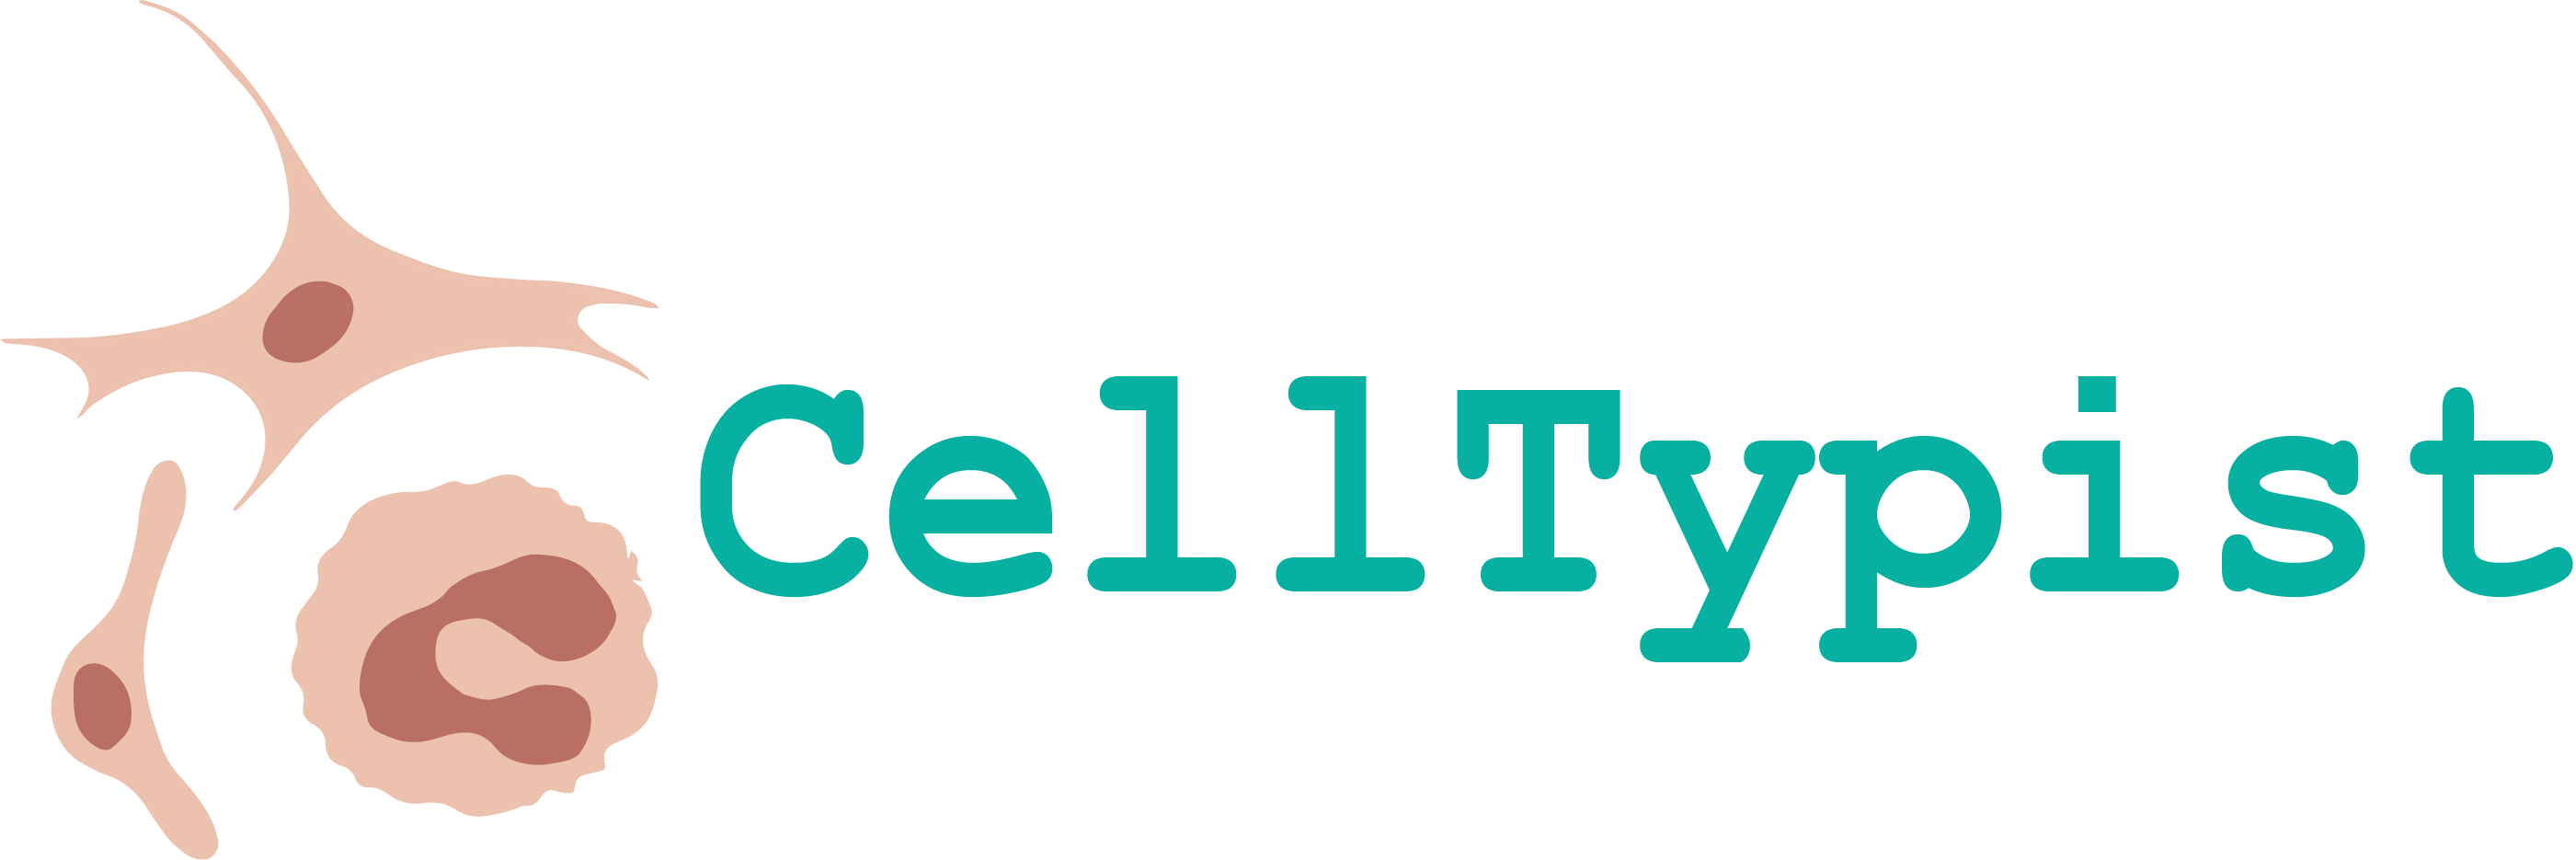

A detailed notebook on how to use CellTypist can be found [here](https://colab.research.google.com/github/Teichlab/celltypist/blob/main/docs/notebook/celltypist_tutorial.ipynb)

In [14]:
!pip install celltypist

In [30]:
import celltypist
# celltypist.models.download_models("Developing_Human_Brain.pkl")
celltypist.models.download_models('Immune_All_High.pkl')

In [16]:
# import celltypist
from celltypist.models import Model
from celltypist import annotate



# Ensure the features (genes) match the model
adata.var_names = adata.var_names.str.upper()  # Convert gene names to uppercase if needed

In [31]:
from celltypist.models import Model

# Load the model
# model = Model.load("Developing_Human_Brain.pkl")
model = Model.load("Immune_All_High.pkl")


# Check model details
print(model)

CellTypist model with 32 cell types and 6639 features
    date: 2022-07-16 08:53:00.959521
    details: immune populations combined from 20 tissues of 18 studies
    source: https://doi.org/10.1126/science.abl5197
    version: v2
    cell types: B cells, B-cell lineage, ..., pDC precursor
    features: A1BG, A2M, ..., ZYX


In [32]:
import scanpy as sc

# Check if 'raw' layer exists and use it
if "raw" in adata.layers:
    adata.X = adata.layers["raw"].copy()
else:
    print("No raw count layer found! Check your original dataset.")

# Normalize counts per cell to 10,000
sc.pp.normalize_total(adata, target_sum=1e4)

# Log1p transformation
sc.pp.log1p(adata)

# Verify min/max values to check if data is in expected range
print(f"Min value: {adata.X.min()}, Max value: {adata.X.max()}")

No raw count layer found! Check your original dataset.
Min value: 0.0, Max value: 6.416547775268555


In [33]:
# Annotate cell types using the CellTypist model
# predictions = annotate(adata, model="Developing_Human_Brain.pkl", mode="best match")
predictions = annotate(adata, model="Immune_All_High.pkl", mode="best match")

# Add predictions to the AnnData object
adata.obs["celltypist_pred"] = predictions.predicted_labels

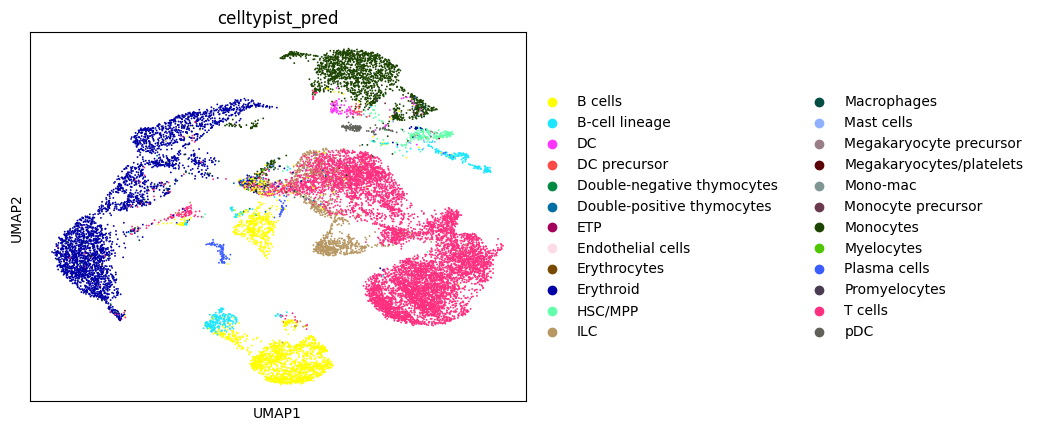

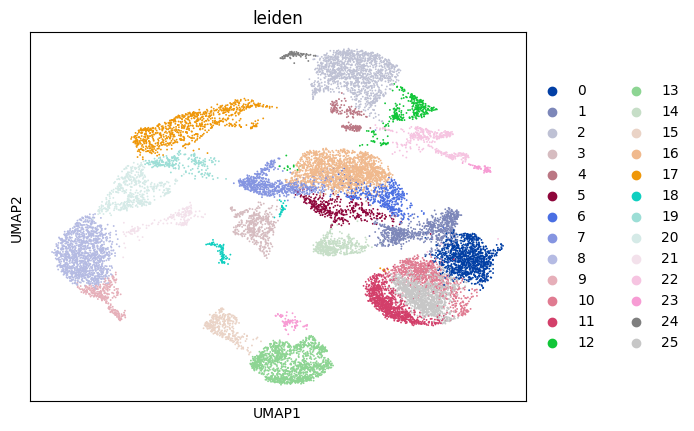

In [34]:
import scanpy as sc

# UMAP plot with CellTypist predictions
sc.pl.umap(adata, color=["celltypist_pred"])
sc.pl.umap(adata, color=["leiden"])

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract leiden clusters and predicted cell types
df = adata.obs[['leiden', 'celltypist_pred']]

# Count occurrences of each cell type per Leiden cluster
counts = df.groupby(['leiden', 'celltypist_pred']).size().unstack(fill_value=0)

# Normalize counts per cluster to get proportions
counts_norm = counts.div(counts.sum(axis=1), axis=0)


<Figure size 1200x600 with 0 Axes>

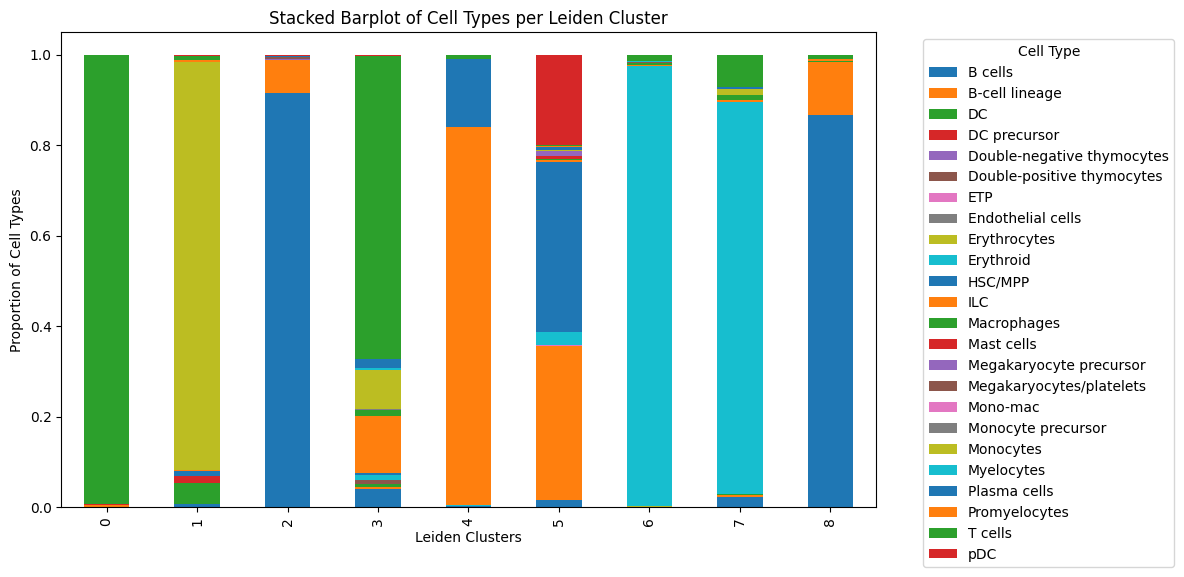

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a discrete color palette (e.g., 'tab10' or 'Set3')
palette = sns.color_palette("tab10", n_colors=len(counts_norm.columns))  # Adjust colors based on unique cell types

# Set figure size
plt.figure(figsize=(12, 6))

# Create a stacked barplot with discrete colors
counts_norm.plot(
    kind='bar',
    stacked=True,
    color=palette,  # Apply discrete colors
    figsize=(12, 6)
)

# Customize plot
plt.xlabel("Leiden Clusters")
plt.ylabel("Proportion of Cell Types")
plt.title("Stacked Barplot of Cell Types per Leiden Cluster")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
# from celltypist import annotate

# # Define the human brain models
# brain_models = [
#     "Developing_Human_Brain.pkl",
#     "Developing_Human_Hippocampus.pkl",
#     "Human_AdultAged_Hippocampus.pkl",
#     "Human_Longitudinal_Hippocampus.pkl",
#     "Adult_Human_PrefrontalCortex.pkl",
#     "Adult_Human_MTG.pkl"
# ]

# # Dictionary to store predictions
# model_predictions = {}

# # Loop through each brain-related model
# for model_name in brain_models:
#     print(f"🔍 Running CellTypist with model: {model_name}")

#     # Annotate cells with the current model
#     predictions = annotate(adata, model=model_name, mode="best match")

#     # Store predictions in a new column
#     model_col_name = f"celltypist_{model_name.replace('.pkl', '')}"  # Clean names
#     adata.obs[model_col_name] = predictions.predicted_labels

#     # Store results
#     model_predictions[model_name] = predictions.predicted_labels

# print("✅ Annotation completed for all human brain models!")

In [ ]:
# # Create a dataframe with all model predictions
# df = adata.obs[["leiden"] + [f"celltypist_{m.replace('.pkl', '')}" for m in brain_models]]

# # Group by leiden clusters and check majority vote per model
# summary = df.groupby("leiden").agg(lambda x: x.value_counts().idxmax())
# summary

Above, majority vote indicates potential identities for each cell cluster. Below, stacked barplots indicate the composition of each cell cluster in terms of potential cell-types.

In [ ]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Define the human brain models
# brain_models = [
#     "Developing_Human_Brain.pkl",
#     "Developing_Human_Hippocampus.pkl",
#     "Human_AdultAged_Hippocampus.pkl",
#     "Human_Longitudinal_Hippocampus.pkl",
#     "Adult_Human_PrefrontalCortex.pkl",
#     "Adult_Human_MTG.pkl"
# ]

# # Loop through each brain-related model and create separate barplots
# for model_name in brain_models:
#     model_col_name = f"celltypist_{model_name.replace('.pkl', '')}"

#     # Create a proportion table
#     celltype_counts = adata.obs.groupby(["leiden", model_col_name]).size().unstack(fill_value=0)
#     celltype_proportions = celltype_counts.div(celltype_counts.sum(axis=1), axis=0)

#     # Plot as a stacked barplot
#     plt.figure(figsize=(12, 6))
#     celltype_proportions.plot(kind="bar", stacked=True, colormap="tab20")
#     plt.ylabel("Proportion")
#     plt.xlabel("Leiden Cluster")
#     plt.title(f"Cell Type Proportions per Leiden Cluster - {model_col_name}")
#     plt.legend(title="Cell Type", bbox_to_anchor=(1, 1), loc="upper left")

#     # Show the plot for the current model
#     plt.show()

# Pathway enrichment

🔬 Pathway Enrichment in Single-Cell Analysis

📌 Overview
Pathway enrichment analysis identifies **biologically relevant pathways** that are significantly enriched in gene expression data. This helps in understanding **cellular responses, functional changes, and regulatory mechanisms** in different conditions.

---

🔹 1. Preprocessing Before Pathway Analysis
Before running enrichment analysis, ensure:
- **Data normalization** (e.g., log transformation, scaling)
- **Identification of differentially expressed genes (DEGs)**
- **Mapping genes to pathway databases (e.g., KEGG, Reactome, GO, MSigDB)**

Example of **DEG analysis** using Scanpy:
```python
import scanpy as sc

# Rank genes by differential expression
sc.tl.rank_genes_groups(adata, groupby="cell_type", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False)


In this notebook we showcase how to use `decoupler` for functional enrichment.

In [ ]:
!pip install decoupler

In [ ]:
import decoupler as dc

The Molecular Signatures Database (MSigDB) is a resource containing a collection of gene sets annotated to different biological processes.


In [ ]:
msigdb = dc.get_resource('MSigDB')
msigdb

In [ ]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
msigdb

To infer functional enrichment scores we will run the Over Representation Analysis `ora` method. As input data it accepts an expression matrix `decoupler.run_ora` or the results of differential expression analysis `decoupler.run_ora_df`. For the former, by default the top 5% of expressed genes by sample are selected as the set of interest `S`, and for the latter a user-defined significance filtering can be used. Once we have S, it builds a contingency table using set operations for each set stored in the gene set resource being used `net`. Using the contingency table, `ora` performs a one-sided Fisher exact test to test for significance of overlap between sets. The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.

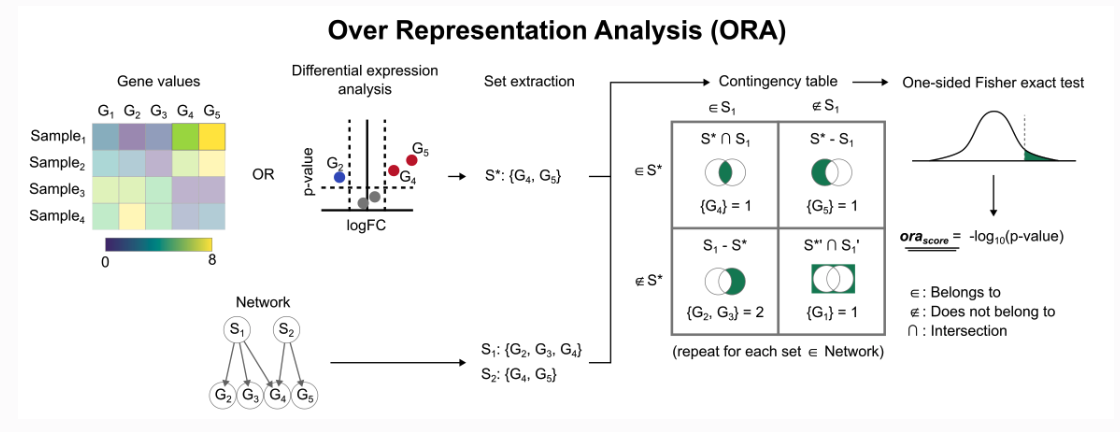

In [ ]:
dc.run_ora(
    mat=adata,
    net=msigdb,
    source='geneset',
    target='genesymbol',
    verbose=True, use_raw=False
)

In [ ]:
adata.obsm['ora_estimate']

In [ ]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

In [ ]:
sc.pl.umap(acts, color=["HALLMARK_KRAS_SIGNALING_DN", 'leiden'], cmap='RdBu_r')
sc.pl.violin(acts, keys=["HALLMARK_KRAS_SIGNALING_DN"], groupby='leiden', rotation=90)

Let’s identify which are the top gene sets per cell type. We can do it by using the function `dc.rank_sources_groups`, which identifies marker gene sets using the same statistical tests available in scanpy’s `scanpy.tl.rank_genes_groups`.

In [ ]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

In [ ]:
n_markers = 3
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers

In [ ]:
sc.pl.matrixplot(acts, source_markers, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')